## Notebook for applying Data Assimilation on seasonal data (Campanian reconstructions)

### Assemble data in the proxy domain using offline (block update) assimilation instead of point-by-point

Author: **N.J. de Winter** (*n.j.de.winter@vu.nl*)<br>
Assistant Professor Vrije Universiteit Amsterdam

**References used in coding**
- Steiger, N.J., Hakim, G.J., Steig, E.J., Battisti, D.S., Roe, G.H., 2014. Assimilation of Time-Averaged Pseudoproxies for Climate Reconstruction. Journal of Climate 27, 426–441. https://doi.org/10.1175/JCLI-D-12-00693.1
- Hakim, G.J., Emile-Geay, J., Steig, E.J., Noone, D., Anderson, D.M., Tardif, R., Steiger, N., Perkins, W.A., 2016. The last millennium climate reanalysis project: Framework and first results. Journal of Geophysical Research: Atmospheres 121, 6745–6764. https://doi.org/10.1002/2016JD024751
- King, J., Tierney, J., Osman, M., Judd, E.J., Anchukaitis, K.J., 2023. DASH: a MATLAB toolbox for paleoclimate data assimilation. Geoscientific Model Development 16, 5653–5683. https://doi.org/10.5194/gmd-16-5653-2023
- Judd, E.J., Tierney, J.E., Lunt, D.J., Montañez, I.P., Huber, B.T., Wing, S.L., Valdes, P.J., 2024. A 485-million-year history of Earth’s surface temperature. Science 385, eadk3705. https://doi.org/10.1126/science.adk3705
- de Winter, N.J., Müller, I.A., Kocken, I.J., Thibault, N., Ullmann, C.V., Farnsworth, A., Lunt, D.J., Claeys, P., Ziegler, M., 2021. Absolute seasonal temperature estimates from clumped isotopes in bivalve shells suggest warm and variable greenhouse climate. Commun Earth Environ 2, 1–8. https://doi.org/10.1038/s43247-021-00193-9

# Load packages

In [116]:
# Load packages
import numpy as np # The 'numpy' package is needed for matrix operations and calculations
import pandas as pd # The 'pandas' package helps us to import and manage data
import math as math # Math package for data cleaning
from scipy import stats # Import scipy.package for confidence intervals
from sklearn.preprocessing import StandardScaler # Import the package for standardizing data
import D47calib as D47c # Import the package for treating clumped isotope data by Daëron and Vermeesch (2023; https://github.com/mdaeron/D47calib)
import matplotlib.pyplot as plt # The 'matplotlib' package contains tools needed to plot our data and results
import seaborn as sns # The 'seaborn' package is used to make our plots look nicer (e.g. enable heatmaps)
import warnings # The 'warnings' package is used to suppress warnings that might occur during the calculations
%matplotlib inline

# PRIOR - MONTHLY
## Load monthly SAT model data

In [117]:
# Load model SAT data as prior and show data structure
Lutetian_SAT = pd.read_csv('Lutetian case/SAT_Individual_values.csv') # Load the data for this assignment into Python and in the Jupyter environment.
Lutetian_SAT.head()

,Month,Temperature
0,1,11.282648
1,1,21.823206
2,1,21.909296
3,1,22.503198
4,1,21.393762


## Load monthly precipitation model data

In [118]:
# Load model precipitation data as prior and show data structure
Lutetian_prec = pd.read_csv('Lutetian case/Precipitation_Individual_values.csv') # Load the data for this assignment into Python and in the Jupyter environment.
Lutetian_prec.head()

,Month,Precipitation
0,1,0.352807
1,1,0.114865
2,1,0.225590
3,1,0.224708
4,1,0.214614


### Combine SAT and precipitation data by modelname

In [119]:
# Add a column to number the rows within each month consecutively
Lutetian_SAT['Cell'] = Lutetian_SAT.groupby('Month').cumcount() + 1
Lutetian_prec['Cell'] = Lutetian_prec.groupby('Month').cumcount() + 1

# Pivot the datasets to create separate columns for each month with 2-letter abbreviations
month_abbreviations = ['ja', 'fb', 'mr', 'ar', 'my', 'jn', 'jl', 'ag', 'sp', 'ot', 'nv', 'dc']
Lutetian_SAT_wide = Lutetian_SAT.pivot(index='Cell', columns='Month', values='Temperature')
Lutetian_SAT_wide.columns = [month_abbreviations[col - 1] for col in Lutetian_SAT_wide.columns]
Lutetian_prec_wide = Lutetian_prec.pivot(index='Cell', columns='Month', values='Precipitation')
Lutetian_prec_wide.columns = [month_abbreviations[col - 1] for col in Lutetian_prec_wide.columns]

# Reset the index to make 'Cell' a column again
Lutetian_SAT_wide.reset_index(inplace = True)
Lutetian_prec_wide.reset_index(inplace = True)

# Merge the datasets of SAT and prec, force suffixes to be added to the column names
Lutetian_models = pd.merge(
    Lutetian_SAT_wide.rename(columns = {c: c+'_SAT' for c in Lutetian_SAT_wide.columns if c != 'Cell'}),
    Lutetian_prec_wide.rename(columns = {c: c+'_prec' for c in Lutetian_prec_wide.columns if c != 'Cell'}),
    on = 'Cell',
    how = 'outer'
)

# Display the combined dataset
Lutetian_models.head()

,Cell,ja_SAT,fb_SAT,mr_SAT,ar_SAT,my_SAT,jn_SAT,jl_SAT,ag_SAT,sp_SAT,...,mr_prec,ar_prec,my_prec,jn_prec,jl_prec,ag_prec,sp_prec,ot_prec,nv_prec,dc_prec
0,1,11.282648,12.089380,13.829187,16.709039,22.411493,27.940820,30.968195,31.072290,26.694391,...,0.288893,0.226607,0.192090,0.275469,0.293100,0.285422,0.386743,0.222989,0.196584,0.262771
1,2,21.823206,22.185327,23.480707,25.735864,30.242242,35.107660,38.680688,39.036523,35.629755,...,0.127827,0.093819,0.057565,0.139227,0.167168,0.280287,0.331272,0.195129,0.079247,0.070105
2,3,21.909296,22.198022,23.222040,25.234583,29.434015,34.056543,38.089227,38.691492,35.554956,...,0.182669,0.119307,0.055575,0.130147,0.110744,0.191268,0.214673,0.151984,0.163265,0.163117
3,4,22.503198,22.530481,23.346246,25.152704,28.970605,33.480951,37.780298,38.492792,35.470605,...,0.158838,0.087854,0.027141,0.030059,0.019739,0.053950,0.112521,0.105006,0.154774,0.174659
4,5,21.393762,21.576868,22.996118,25.669275,30.826440,36.038263,40.872888,40.882013,36.701257,...,0.162401,0.100587,0.032203,0.051653,0.045900,0.074113,0.118162,0.105596,0.172400,0.192902


### Convert SAT model data to D47 domain using the regression by Daëron and Vermeesch (2023) and propagate uncertainty in the calibration

In [120]:
# Apply T47()-function from the D47calib package to all SAT columns
# Identify the SAT columns
SAT_columns = [col for col in Lutetian_models.columns if col.endswith('_SAT')]

# Apply the conversion function to the SAT columns and add new columns for D47 and D47_SE
for col in SAT_columns:
    base_col_name = col.replace('_SAT', '') # Remove the '_SAT' suffix from the column name
    Lutetian_models[f'{base_col_name}_D47'], Lutetian_models[f'{base_col_name}_D47_SE'] = zip(*Lutetian_models[col].apply(
        lambda x: D47c.OGLS23.T47(T = x) if not pd.isna(x) else (np.nan, np.nan)
    )) # Use zip() to unpack the tuple returned by the apply() method and apply the T47()-function to each value in the column

# Display the combined data with D47 and D47_SE columns
D47_columns = [col for col in Lutetian_models.columns if col.endswith('_D47')]
D47_se_columns = [col for col in Lutetian_models.columns if '_D47_SE' in col]
print("D47 values for all model outcomes:\n", Lutetian_models[D47_columns].head())
print("Calibration standard errors for all model outcomes:\n", Lutetian_models[D47_se_columns].head())

D47 values for all model outcomes:
      ja_D47    fb_D47    mr_D47    ar_D47    my_D47    jn_D47    jl_D47  \
0  0.637865  0.635067  0.629115  0.619502  0.601307  0.584664  0.575942   
1  0.603134  0.602008  0.598014  0.591188  0.578009  0.564439  0.554885   
2  0.602866  0.601969  0.598808  0.592691  0.580329  0.567315  0.556444   
3  0.601023  0.600939  0.598426  0.592938  0.581667  0.568903  0.557261   
4  0.604475  0.603903  0.599502  0.591387  0.576345  0.561918  0.549188   

     ag_D47    sp_D47    ot_D47    nv_D47    dc_D47  
0  0.575647  0.588334  0.607248  0.624917  0.635158  
1  0.553952  0.563022  0.577000  0.590104  0.599447  
2  0.554857  0.563225  0.577214  0.590487  0.599549  
3  0.555379  0.563453  0.576950  0.588872  0.597272  
4  0.549164  0.560136  0.577425  0.591217  0.600207  
Calibration standard errors for all model outcomes:
    ja_D47_SE  fb_D47_SE  mr_D47_SE  ar_D47_SE  my_D47_SE  jn_D47_SE  \
0   0.001252   0.001233   0.001196   0.001144   0.001073   0.0010

## Calculate the monthly prior for model SAT-derived D47 values with propagated uncertainty

In [121]:
# Create list of month names
months = ['ja', 'fb', 'mr', 'ar', 'my', 'jn', 'jl', 'ag', 'sp', 'ot', 'nv', 'dc']

# Set the weights of the data based on the standard errors
weights_monthly = 1 / Lutetian_models[[f"{month}_D47_SE" for month in months]] ** 2

# Change the column suffixes from "_D47_SE" to "_D47" in weights_monthly to match the headers of the D47 matrix later for multiplication
weights_monthly.columns = [col.replace('_D47_SE', '_D47') for col in weights_monthly.columns]

# Prior D47 estimates from climate models (weighted mean)
mu_prior_D47_monthly = np.array((Lutetian_models[[f"{month}_D47" for month in months]] * weights_monthly).sum(axis = 0, skipna = True) / weights_monthly.sum(axis = 0, skipna = True)) # Calculate weighted monthal mean D47 values and convert to numpy array

# Decompose variance within and between model outcomes
model_variances = Lutetian_models[[f"{month}_D47" for month in months]].var(axis = 0, ddof = 1)  # Compute variance across models
measurement_variances = (Lutetian_models[[f"{month}_D47_SE" for month in months]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements

# Covariance between months in prior D47 estimates from climate models (weighted covariance matrix)
cov_raw_monthly = np.cov(Lutetian_models[[f"{month}_D47" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_D47_monthly = cov_raw_monthly.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
np.fill_diagonal(cov_prior_D47_monthly, np.diagonal(cov_raw_monthly) + measurement_variances)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)

# Store copy of original prior means to keep when later updating the prior
mu_prior_D47_monthly_original, cov_prior_D47_monthly_original = mu_prior_D47_monthly.copy(), cov_prior_D47_monthly.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_D47_monthly = np.sqrt(np.diag(cov_prior_D47_monthly))

print(mu_prior_D47_monthly)
print(std_prior_D47_monthly)

[0.62006985 0.61787124 0.61269573 0.60374682 0.58703137 0.57294061
 0.56290407 0.56283341 0.57307851 0.59111554 0.60696862 0.61709809]
[0.01142741 0.01018869 0.0090148  0.00801557 0.00738831 0.00779214
 0.00785649 0.00725533 0.00718243 0.00905268 0.01135674 0.01208698]


## Plot the monthly prior for model SST-derived D47 values with propagated uncertainty

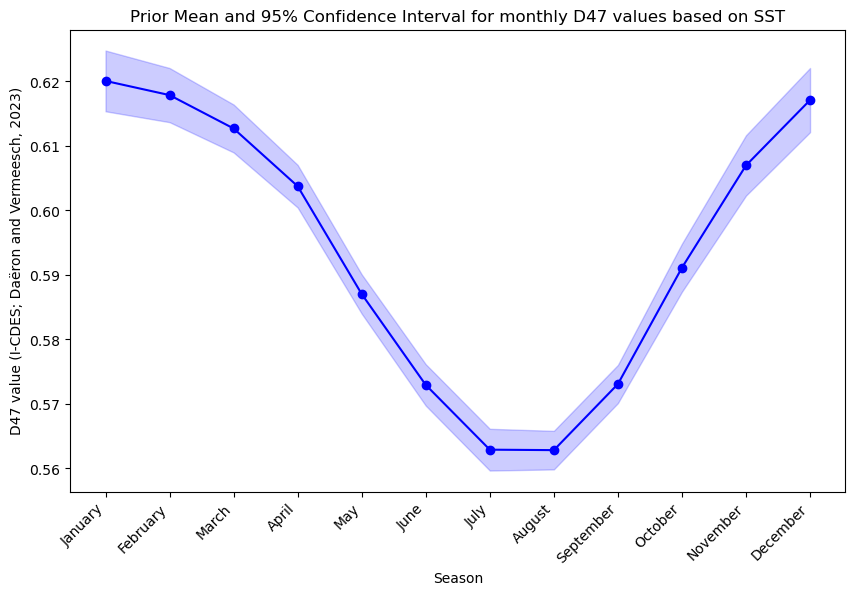

In [122]:
# Establish prior distribution based on monthly Lutetian model outcomes

# Set dimensions of data
n_models_monthly = len(Lutetian_models["Cell"]) # Find the total number of models (use monthly data because monthly data has this column duplicated 3 times)

# Define month names
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plot monthly prior distribution
# Plotting the prior mean and uncertainty
months_scale = np.arange(len(months)) + 1 # Create monthly scale

plt.figure(figsize = (10, 6))
plt.plot(months_scale, mu_prior_D47_monthly, label = 'Prior D47 Mean', color = 'b', marker = 'o')
plt.title('Prior Mean and 95% Confidence Interval for monthly D47 values based on SST')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')

# Adding 95% confidence intervals (mean ± 1.96 * standard deviation)
plt.fill_between(months_scale,
    mu_prior_D47_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly / np.sqrt(n_models_monthly),
    mu_prior_D47_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# Update the x-axis with month names
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.show() # Show plot

## Calculate the monthly prior for model SAT and precipitation values

In [123]:
# Prior SAT & prec estimates from climate models (mean)
mu_prior_prec_monthly = np.array(Lutetian_models[[f"{month}_prec" for month in months]].mean(axis = 0, skipna = True))
mu_prior_SAT_monthly = np.array(Lutetian_models[[f"{month}_SAT" for month in months]].mean(axis = 0, skipna = True))

# Covariance between months in prior SAT & prec estimates from climate models (covariance matrix)
cov_prior_prec_monthly = np.cov(Lutetian_models[[f"{month}_prec" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_SAT_monthly = np.cov(Lutetian_models[[f"{month}_SAT" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)

# Store copy of original prior means to keep when later updating the prior
mu_prior_prec_monthly_original, cov_prior_prec_monthly_original = mu_prior_prec_monthly.copy(), cov_prior_prec_monthly.copy()
mu_prior_SAT_monthly_original, cov_prior_SAT_monthly_original = mu_prior_SAT_monthly.copy(), cov_prior_SAT_monthly.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_prec_monthly = np.sqrt(np.diag(cov_prior_prec_monthly))
std_prior_SAT_monthly = np.sqrt(np.diag(cov_prior_SAT_monthly))

print(mu_prior_prec_monthly)
print(std_prior_prec_monthly)

[0.20503649 0.20900211 0.21310989 0.19671564 0.14064345 0.16901619
 0.20951558 0.19801853 0.19421264 0.16398235 0.18276501 0.19433419]
[0.06656403 0.06261988 0.05604318 0.06767304 0.07139255 0.09812866
 0.12533398 0.10071089 0.0756273  0.0488595  0.0686841  0.0680282 ]


## Plot the monthly prior for model SAT and precipitation values

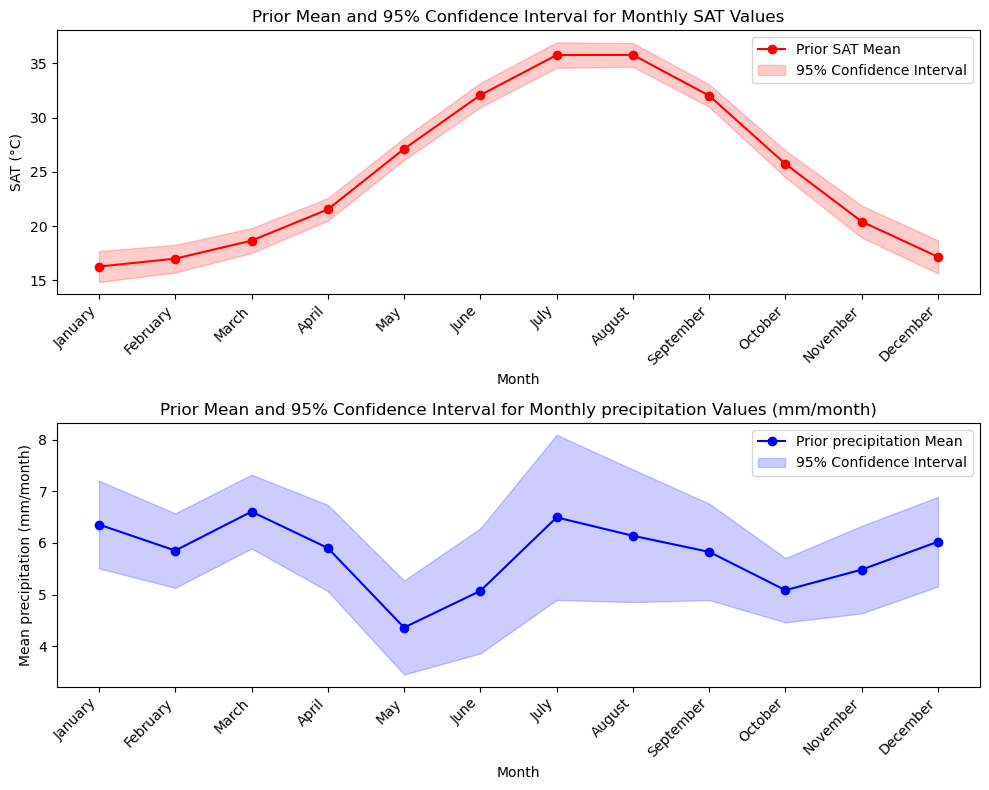

In [124]:
# Plot the prior distribution and confidence envelopes per season for SAT & prec
plt.figure(figsize=(10, 8))

# Plot the prior mean for SAT
plt.subplot(2, 1, 1)
plt.plot(months_scale, mu_prior_SAT_monthly, label='Prior SAT Mean', marker = 'o', color = 'r')
plt.fill_between(months_scale,
                 mu_prior_SAT_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
                 mu_prior_SAT_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
                 alpha=0.2,
                 label='95% Confidence Interval',
                 color='r')
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Prior Mean and 95% Confidence Interval for Monthly SAT Values')
plt.xlabel('Month')
plt.ylabel('SAT (°C)')
plt.legend()

# Plot the prior mean for precipitation (converted to mm/month)
plt.subplot(2, 1, 2)
days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]  # Number of days in each month
mm_per_day_to_mm_per_month = np.array(days_in_month)  # Conversion factor

# Convert precipitation values to mm/month
mu_prior_prec_monthly_mm = mu_prior_prec_monthly * mm_per_day_to_mm_per_month
std_prior_prec_monthly_mm = std_prior_prec_monthly * mm_per_day_to_mm_per_month

plt.plot(months_scale, mu_prior_prec_monthly_mm, label='Prior precipitation Mean', marker='o', color='b')
plt.fill_between(months_scale,
                 mu_prior_prec_monthly_mm - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_prec_monthly_mm / np.sqrt(n_models_monthly),
                 mu_prior_prec_monthly_mm + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_prec_monthly_mm / np.sqrt(n_models_monthly),
                 alpha=0.2,
                 label='95% Confidence Interval',
                 color='b')
plt.xticks(months_scale, month_names, rotation=45, ha="right")
plt.title('Prior Mean and 95% Confidence Interval for Monthly precipitation Values (mm/month)')
plt.xlabel('Month')
plt.ylabel('Mean precipitation (mm/month)')
plt.legend()

plt.tight_layout()
plt.show()

## Calculate the monthly covariance matrix for D47 and SAT values

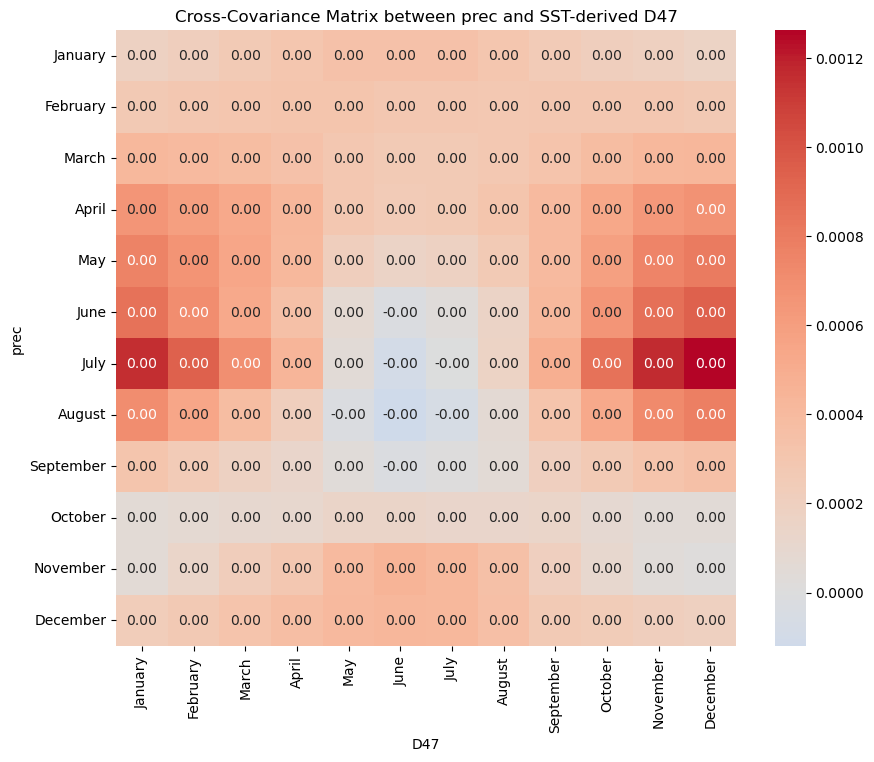

In [125]:
# Extract the relevant columns for precipitation, SST, and D47
prec_columns_monthly = [f"{month}_prec" for month in months]
D47_columns_monthly = [f"{month}_D47" for month in months]

# Combine the relevant columns into a single dataframe
combined_data_monthly = Lutetian_models[prec_columns_monthly + D47_columns_monthly]

# Calculate the covariance matrix for the combined data
cov_combined_monthly = np.cov(combined_data_monthly.dropna(), rowvar = False)

# Extract the covariance matrices for precipitation, SST, and D47
cov_prec_monthly = cov_combined_monthly[:len(months), :len(months)]
cov_D47_monthly = cov_combined_monthly[len(months):, len(months):]

# Extract the cross-covariance matrix
cross_cov_prec_D47_monthly = cov_combined_monthly[:len(months), len(months):]

# Plot a heatmap of the cross-covariance matrix
plt.figure(figsize = (10, 8))
sns.heatmap(
    cross_cov_prec_D47_monthly,
    annot = True,
    fmt = ".2f",
    cmap = "coolwarm",
    center = 0,
    xticklabels = month_names,
    yticklabels = month_names
)
plt.title("Cross-Covariance Matrix between prec and SST-derived D47")
plt.xlabel("D47")
plt.ylabel("prec")
plt.show()

## Create combined monthly state vector

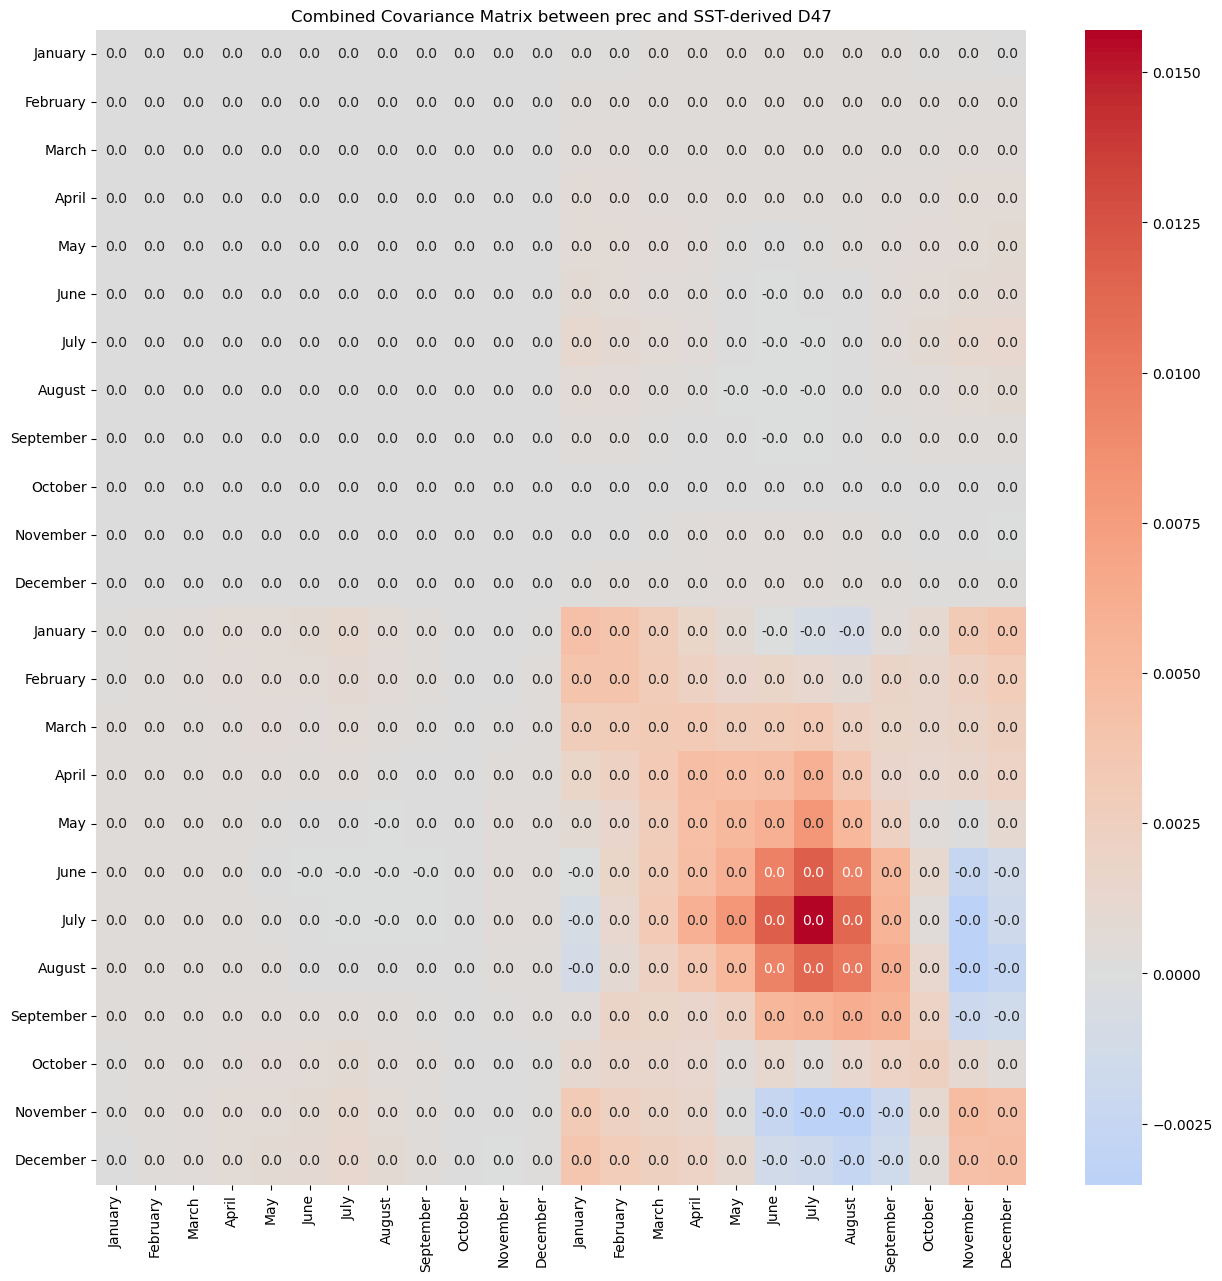

In [126]:
# Combine the prior means of D47 and precipitation into a single state vector
mu_prior_monthly_combined = np.concatenate((mu_prior_D47_monthly, mu_prior_prec_monthly))

# Combine the covariance matrices of D47 and prec, including the cross-covariance
cov_prior_monthly_combined = np.block([
    [cov_prior_D47_monthly, cross_cov_prec_D47_monthly],
    [cross_cov_prec_D47_monthly.T, cov_prior_prec_monthly]
])

# Plot a heatmap of the combined covariance matrix
plt.figure(figsize = (15, 15))
sns.heatmap(
    cov_prior_monthly_combined,
    annot = True,
    fmt = ".1f",
    cmap = "coolwarm",
    center = 0,
    xticklabels = month_names + month_names,
    yticklabels = month_names + month_names
)
plt.title("Combined Covariance Matrix between prec and SST-derived D47")
plt.show()

# PRIOR - SEASONAL

## Seasonal model data (convert the model data to seasonal means)

In [127]:
# Define the seasons
seasons = {
    "winter": ["dc", "ja", "fb"],
    "spring": ["mr", "ar", "my"],
    "summer": ["jn", "jl", "ag"],
    "autumn": ["sp", "ot", "nv"],
}

# Stack monthly columns to create a seasonal dataframes
# Initialize dictionaries to store seasonal data
Lutetian_models_seasonal_dict = {}

# Identify the columns to process (all except the Cell column)
columns_to_process = [col for col in Lutetian_models.columns if any(suffix in col for suffix in ['_SAT', '_prec', '_D47', '_D47_SE'])]

# Process each season
for season, months in seasons.items(): # Iterate over the seasons and corresponding months
    for col in columns_to_process: # Iterate over the columns to process
        base_col_name = col.split('_')[0] # Extract the base column name
        suffix = '_'.join(col.split('_')[1:]) # Extract the suffix
        if base_col_name in months: # Check if the column corresponds to the current season
            season_col_name = f"{season}_{suffix}" # Create the new column name
            if season_col_name not in Lutetian_models_seasonal_dict: # Check if the new column name already exists in the seasonal data
                Lutetian_models_seasonal_dict[season_col_name] = [] # If not, tnitialize a new column in the seasonal data means
            Lutetian_models_seasonal_dict[season_col_name].append(Lutetian_models[col])

# Combine the seasonal data into a single dataframe
Lutetian_models_seasonal = pd.DataFrame()
for season_col_name, data in Lutetian_models_seasonal_dict.items():
    # Concatenate the data for each season and reshape it properly
    concatenated_data = pd.concat(data, axis = 0).reset_index(drop = True)
    Lutetian_models_seasonal[season_col_name] = concatenated_data

# Add model names
Lutetian_models_seasonal["Cell"] = np.tile(Lutetian_models["Cell"].values, 3) # Repeat the model names for each season

# Display the new seasonal DataFrame
D47_columns_seasonal = [col for col in Lutetian_models_seasonal.columns if col.endswith('_D47')]
D47_se_columns_seasonal = [col for col in Lutetian_models_seasonal.columns if '_D47_SE' in col]
# Lutetian_models_seasonal.head()
print("Seasonal D47 values for all SST model outcomes:\n", Lutetian_models_seasonal[D47_columns_seasonal].head())
print("Calibration standard errors for all SST model outcomes:\n", Lutetian_models_seasonal[D47_se_columns_seasonal].head())

Seasonal D47 values for all SST model outcomes:
    winter_D47  spring_D47  summer_D47  autumn_D47
0    0.637865    0.629115    0.584664    0.588334
1    0.603134    0.598014    0.564439    0.563022
2    0.602866    0.598808    0.567315    0.563225
3    0.601023    0.598426    0.568903    0.563453
4    0.604475    0.599502    0.561918    0.560136
Calibration standard errors for all SST model outcomes:
    winter_D47_SE  spring_D47_SE  summer_D47_SE  autumn_D47_SE
0       0.001252       0.001196       0.001044       0.001047
1       0.001079       0.001065       0.001051       0.001053
2       0.001078       0.001067       0.001047       0.001053
3       0.001073       0.001066       0.001046       0.001053
4       0.001083       0.001069       0.001055       0.001059


## Calculate the seasonal prior for model SAT-derived D47 values with propagated uncertainty

In [128]:
# Define the seasons
seasons = ["winter", "spring", "summer", "autumn"]

# Set the weights of the data based on the standard errors
weights_seasonal = 1 / Lutetian_models_seasonal[[f"{season}_D47_SE" for season in seasons]] ** 2

# Change the column suffixes from "_D47_SE" to "_D47" in weights_seasonal to match the headers of the D47 matrix later for multiplication
weights_seasonal.columns = [col.replace('_D47_SE', '_D47') for col in weights_seasonal.columns]

# Prior D47 estimates from climate models (weighted mean)
mu_prior_D47_seasonal = np.array((Lutetian_models_seasonal[[f"{season}_D47" for season in seasons]] * weights_seasonal).sum(axis = 0, skipna = True) / weights_seasonal.sum(axis = 0, skipna = True)) # Calculate weighted seasonal mean D47 values and convert to numpy array

# Decompose variance within and between model outcomes
model_variances = Lutetian_models_seasonal[[f"{season}_D47" for season in seasons]].var(axis = 0, ddof = 1)  # Compute variance across models
measurement_variances = (Lutetian_models_seasonal[[f"{season}_D47_SE" for season in seasons]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements

# Covariance between seasons in prior D47 estimates from climate models (weighted covariance matrix)
cov_raw_seasonal = np.cov(Lutetian_models_seasonal[[f"{season}_D47" for season in seasons]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_D47_seasonal = cov_raw_seasonal.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
np.fill_diagonal(cov_prior_D47_seasonal, np.diagonal(cov_raw_seasonal) + measurement_variances)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)

# Store copy of original prior means to keep when later updating the prior
mu_prior_D47_seasonal_original, cov_prior_D47_seasonal_original = mu_prior_D47_seasonal.copy(), cov_prior_D47_seasonal.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_D47_seasonal = np.sqrt(np.diag(cov_prior_D47_seasonal))

## Plot the seasonal prior for model SAT-derived D47 values with propagated uncertainty

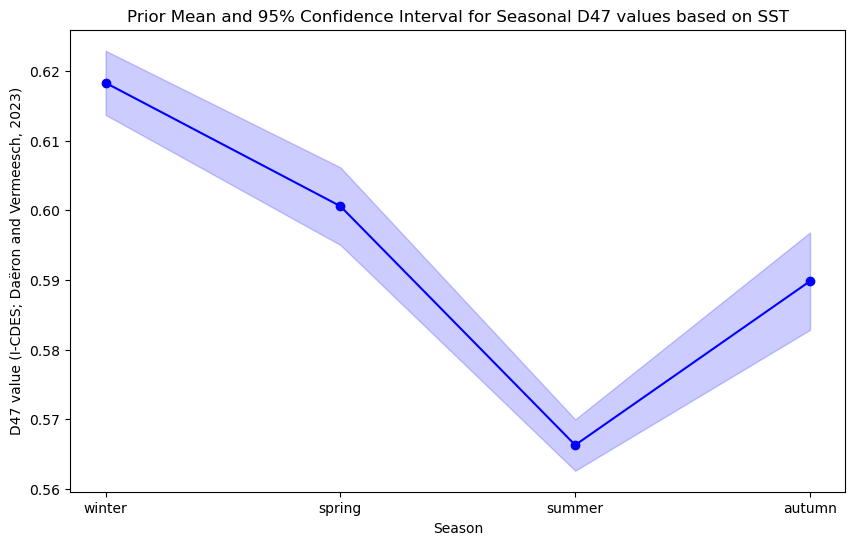

In [129]:
# Establish prior distribution based on seasonal Lutetian model outcomes

# Set dimensions of data
n_models_seasonal = len(Lutetian_models["Cell"]) # Find the total number of models (use monthly data because seasonal data has this column duplicated 3 times)

# Plot seasonal prior distribution
# Plotting the prior mean and uncertainty
seasons_scale = np.arange(len(seasons)) + 1 # Create seasonal scale

plt.figure(figsize = (10, 6))
plt.plot(seasons_scale, mu_prior_D47_seasonal, label = 'Prior D47 Mean', color = 'b', marker = 'o')
plt.title('Prior Mean and 95% Confidence Interval for Seasonal D47 values based on SST')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')

# Adding 95% confidence intervals (mean ± 1.96 * standard deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# Update the x-axis with month names
plt.xticks(seasons_scale, seasons)
plt.show() # Show plot

## Calculate the seasonal prior for model SAT and precipitation values

In [130]:
# Prior SAT & precipitation estimates from climate models (mean)
mu_prior_prec_seasonal = np.array(Lutetian_models_seasonal[[f"{season}_prec" for season in seasons]].mean(axis = 0, skipna = True))
mu_prior_SAT_seasonal = np.array(Lutetian_models_seasonal[[f"{season}_SAT" for season in seasons]].mean(axis = 0, skipna = True))

# Covariance between seasons in prior SAT & precipitation estimates from climate models (covariance matrix)
cov_prior_prec_seasonal = np.cov(Lutetian_models_seasonal[[f"{season}_prec" for season in seasons]].dropna(), rowvar=False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_SAT_seasonal = np.cov(Lutetian_models_seasonal[[f"{season}_SAT" for season in seasons]].dropna(), rowvar=False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)

# Store copy of original prior means to keep when later updating the prior
mu_prior_prec_seasonal_original, cov_prior_prec_seasonal_original = mu_prior_prec_seasonal.copy(), cov_prior_prec_seasonal.copy()
mu_prior_SAT_seasonal_original, cov_prior_SAT_seasonal_original = mu_prior_SAT_seasonal.copy(), cov_prior_SAT_seasonal.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_prec_seasonal = np.sqrt(np.diag(cov_prior_prec_seasonal))
std_prior_SAT_seasonal = np.sqrt(np.diag(cov_prior_SAT_seasonal))

print(mu_prior_prec_seasonal)
print(std_prior_prec_seasonal)

[0.20279093 0.18348966 0.19218344 0.18032   ]
[0.06518114 0.07164279 0.10863477 0.06570094]


## Plot the seasonal prior for model SAT and precipitation values

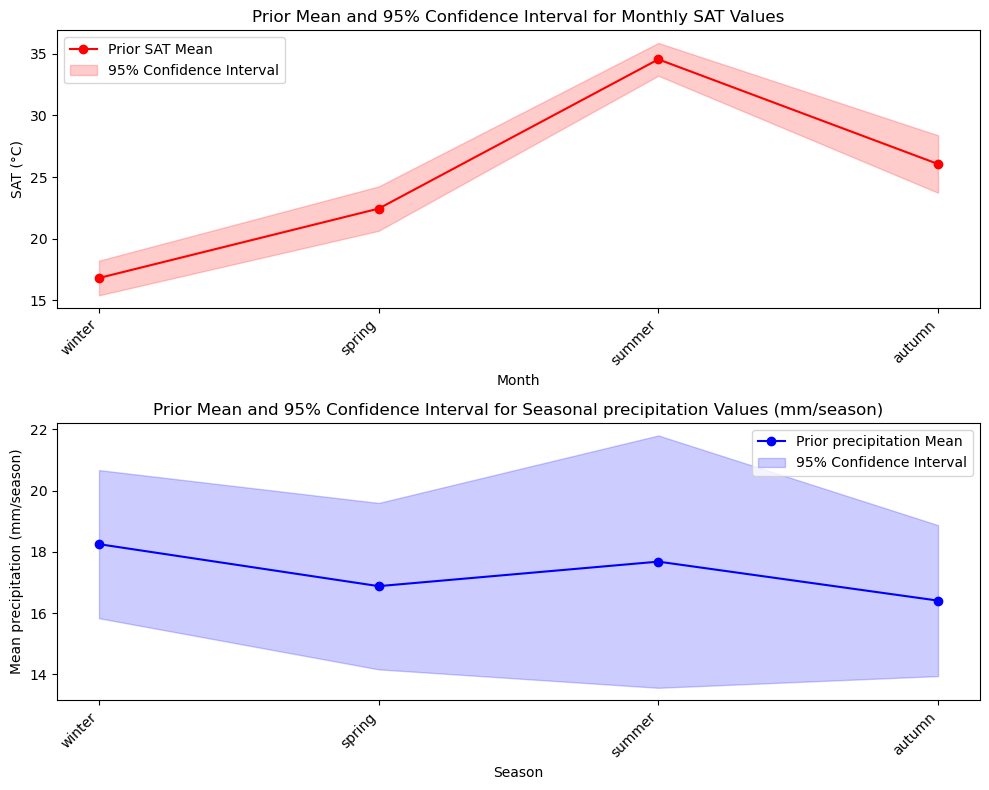

In [131]:
# Plot the prior distribution and confidence envelopes per season for SAT & prec
plt.figure(figsize=(10, 8))

# Plot the prior mean for SAT
plt.subplot(2, 1, 1)
plt.plot(seasons_scale, mu_prior_SAT_seasonal, label='Prior SAT Mean', marker='o', color='r')
plt.fill_between(seasons_scale,
                 mu_prior_SAT_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
                 mu_prior_SAT_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
                 alpha=0.2,
                 label='95% Confidence Interval',
                 color='r')
plt.xticks(seasons_scale, seasons, rotation=45, ha="right")
plt.title('Prior Mean and 95% Confidence Interval for Monthly SAT Values')
plt.xlabel('Month')
plt.ylabel('SAT (°C)')
plt.legend(loc='upper left')

# Plot the prior mean for precipitation (converted to mm/season)
plt.subplot(2, 1, 2)
days_in_season = [31 + 28 + 31, 31 + 30 + 31, 30 + 31 + 31, 30 + 31 + 30]  # Number of days in each season
mm_per_day_to_mm_per_season = np.array(days_in_season)  # Conversion factor

# Convert precipitation values to mm/season
mu_prior_prec_seasonal_mm = mu_prior_prec_seasonal * mm_per_day_to_mm_per_season
std_prior_prec_seasonal_mm = std_prior_prec_seasonal * mm_per_day_to_mm_per_season

plt.plot(seasons_scale, mu_prior_prec_seasonal_mm, label='Prior precipitation Mean', marker='o', color='b')
plt.fill_between(seasons_scale,
                 mu_prior_prec_seasonal_mm - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_prec_seasonal_mm / np.sqrt(n_models_seasonal),
                 mu_prior_prec_seasonal_mm + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_prec_seasonal_mm / np.sqrt(n_models_seasonal),
                 alpha=0.2,
                 label='95% Confidence Interval',
                 color='b')
plt.xticks(seasons_scale, seasons, rotation=45, ha="right")
plt.title('Prior Mean and 95% Confidence Interval for Seasonal precipitation Values (mm/season)')
plt.xlabel('Season')
plt.ylabel('Mean precipitation (mm/season)')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Calculate the seasonal covariance matrix for D47 and precipitation values

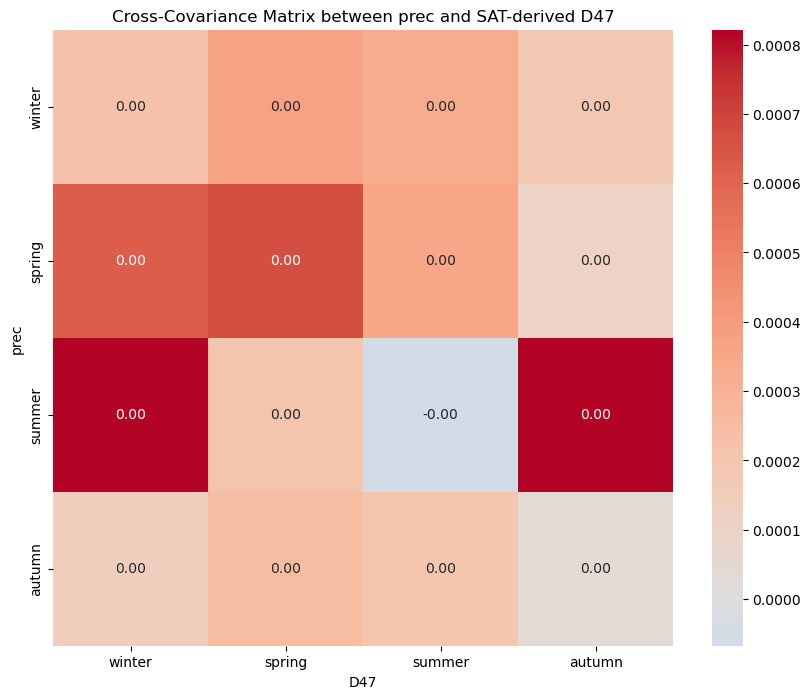

In [132]:
# Extract the relevant columns for precipitation, SST, and D47
prec_columns_seasonal = [f"{season}_prec" for season in seasons]
d47_columns_seasonal = [f"{season}_D47" for season in seasons]

# Combine the relevant columns into a single dataframe
combined_data_seasonal = Lutetian_models_seasonal[prec_columns_seasonal + d47_columns_seasonal]

# Calculate the covariance matrix for the combined data
cov_combined_seasonal = np.cov(combined_data_seasonal.dropna(), rowvar = False)

# Extract the covariance matrices for precipitation, SST, and D47
cov_prec_seasonal = cov_combined_seasonal[:len(seasons), :len(seasons)]
cov_D47_seasonal = cov_combined_seasonal[len(seasons):, len(seasons):]

# Extract the cross-covariance matrix
cross_cov_prec_D47_seasonal = cov_combined_seasonal[:len(seasons), len(seasons):]

# Plot a heatmap of the cross-covariance matrix
plt.figure(figsize = (10, 8))
sns.heatmap(
    cross_cov_prec_D47_seasonal,
    annot = True,
    fmt = ".2f",
    cmap = "coolwarm",
    center = 0,
    xticklabels = seasons,
    yticklabels = seasons
)
plt.title("Cross-Covariance Matrix between prec and SAT-derived D47")
plt.xlabel("D47")
plt.ylabel("prec")
plt.show()

## Create combined seasonal state vector

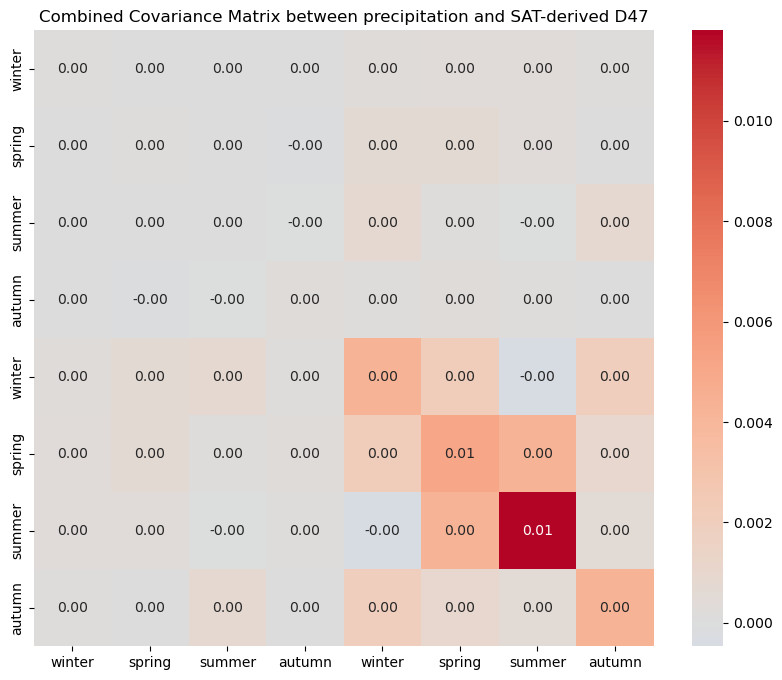

In [133]:
# Combine the prior means of D47 and precipitation into a single state vector
mu_prior_seasonal_combined = np.concatenate((mu_prior_D47_seasonal, mu_prior_prec_seasonal))

# Combine the covariance matrices of D47 and precipitation, including the cross-covariance
cov_prior_seasonal_combined = np.block([
    [cov_prior_D47_seasonal, cross_cov_prec_D47_seasonal],
    [cross_cov_prec_D47_seasonal.T, cov_prior_prec_seasonal]
])

# Plot a heatmap of the combined covariance matrix
plt.figure(figsize = (10, 8))
sns.heatmap(
    cov_prior_seasonal_combined,
    annot = True,
    fmt = ".2f",
    cmap = "coolwarm",
    center = 0,
    xticklabels = seasons + seasons,
    yticklabels = seasons + seasons
)
plt.title("Combined Covariance Matrix between precipitation and SAT-derived D47")
plt.show()

# OBSERVATIONS
## Load clumped data for updating
### Monthly data from Paris Basin Campanile giganteum paper (Van Horebeek et al. 2025)

In [134]:
# Load seasonal measurements and format them into a dictionary
# This is precompiled seasonal data per specimen and therefore does not come with a time uncertainty
Lutetian_seasonally_aggregated_data = pd.read_csv('Lutetian case/D47_season_data_calc.csv') # Load the data for seasonal averages
Lutetian_seasonally_aggregated_data_dict = Lutetian_seasonally_aggregated_data.to_dict('records') # Convert to dictionary with column headers as keys

# Add an entry for the time uncertainty (which is always zero in this case, because data is already aggregated monthly)
for record in Lutetian_seasonally_aggregated_data_dict:
    record["Season_err"] = 0 # Set the time uncertainty to zero
    record["D47_se"] = record["D47_SD"] / np.sqrt(record["count"]) # Calculate the standard error of the D47 value

print(Lutetian_seasonally_aggregated_data_dict[0]) # Print to check the structure of the data

{'Season': 'summer', 'Whorl...P.or.T': 'AW', 'X': 'AX', 'D47_mean': 0.589860492, 'D47_SD': 0.042653301, 'count': 62, 'd18O': -2.150527044, 'd18O_SD': 0.312787802, 'T': 27.8927760016542, 'CL95': 0.010920335, 'CL95_T': 3.824099323, 'd18Osw': -0.270163909978302, 'DOY': 190.657202070161, 'Tmin': 24.2091835112118, 'Tmax': 31.7167435907819, 'dwmin': -1.11891794003415, 'dwmax': 0.61093461286219, 'Season_err': 0, 'D47_se': 0.005416974643977352}


### Raw data at the sample level

In [135]:
# Load measurements and format them into a dictionary
# These are the actual individual D47 measurements and ShellChron outcomes and thus come with a time uncertainty which can be propagated.
Lutetian_D47_data = pd.read_csv('Lutetian case/D47_sample_data_calc.csv') # Load data for individual D47 measurements and ShellChron outcomes
Lutetian_D47_data_dict = Lutetian_D47_data.to_dict('records') # Convert to dictionary with column headers as keys

# Add an entry for the time uncertainty (which is always zero in this case, because there is no time uncertainty in the raw data)
for record in Lutetian_D47_data_dict:
    record["Month_err"] = 0 # Set the time uncertainty to zero
    record["D47_SD"] = 0.029 # Assign external standard deviation to the D47 value (based on reproducibility of IAEA-C2 measurements)

print(Lutetian_D47_data_dict[0]) # Print to check the structure of the data

{'ID': 'AQ025', 'D': 794.0, 'Run': 508, 'Row': 27, 'Sample.intensity': 18607, 'X49.parameter': 0.038, 'D47_raw': -0.243, 'D47_SD': 0.029, 'D47_final': 0.568, 'Temperature': 34.1, 'd18O': -2.79, 'd13C': 0.67, 'Whorl': 'AQ', 'sample_nr': 25, 'Year': 2, 'season_manual': 'summer', 'd18O_SD': 0.1, 'day': 556.1204751, 'season_label': 3, 'T_d18O': 28.5856, 'DOY': 191.1204751, 'Season': 'summer', 'Month_err': 0}


## Summarize proxy data to seasonal bins

In [136]:
# Define the seasons for proxy data
proxy_seasons = {
    0: [12, 1, 2],
    1: [3, 4, 5],
    2: [6, 7, 8],
    3: [9, 10, 11]
}

# Define seasonal IDs based on season names
season_names = {
    0: "winter",
    1: "spring",
    2: "summer",
    3: "autumn"
}

# Add seasonal ID to the proxy data
for record in Lutetian_D47_data_dict:
    record["Season_err"] = 0 # Set the season error to zero
    month = math.ceil(record["DOY"] / 365 * 12) # Round up the modelled age to the nearest month
    if month == 0:
        month = 1 # Round exact 0 values up to 1 to prevent month indices of 0 (month should be in 1:12)
    record["month_score"] = month - 1 # Add the month score to the record (0-indexed)
    for season, months in proxy_seasons.items():
        if month in months:
            record["season_score"] = season
            break

for record in Lutetian_seasonally_aggregated_data_dict:
    record["Season_err"] = 0 # Set the season error to zero
    for season_score, season_name in season_names.items():
        if record["Season"] == season_name:
            record["season_score"] = season_score
            break

print(Lutetian_D47_data_dict[0]) # Print to check the structure of the data
print(Lutetian_seasonally_aggregated_data_dict[0]) # Print to check the structure of the data

{'ID': 'AQ025', 'D': 794.0, 'Run': 508, 'Row': 27, 'Sample.intensity': 18607, 'X49.parameter': 0.038, 'D47_raw': -0.243, 'D47_SD': 0.029, 'D47_final': 0.568, 'Temperature': 34.1, 'd18O': -2.79, 'd13C': 0.67, 'Whorl': 'AQ', 'sample_nr': 25, 'Year': 2, 'season_manual': 'summer', 'd18O_SD': 0.1, 'day': 556.1204751, 'season_label': 3, 'T_d18O': 28.5856, 'DOY': 191.1204751, 'Season': 'summer', 'Month_err': 0, 'Season_err': 0, 'month_score': 6, 'season_score': 2}
{'Season': 'summer', 'Whorl...P.or.T': 'AW', 'X': 'AX', 'D47_mean': 0.589860492, 'D47_SD': 0.042653301, 'count': 62, 'd18O': -2.150527044, 'd18O_SD': 0.312787802, 'T': 27.8927760016542, 'CL95': 0.010920335, 'CL95_T': 3.824099323, 'd18Osw': -0.270163909978302, 'DOY': 190.657202070161, 'Tmin': 24.2091835112118, 'Tmax': 31.7167435907819, 'dwmin': -1.11891794003415, 'dwmax': 0.61093461286219, 'Season_err': 0, 'D47_se': 0.005416974643977352, 'season_score': 2}


## Prepare measurement and observation matrices

### Define a wrapped normal distribution to allow uncertainty in the time domain to flow around the year

In [137]:
# Function to calculate wrapped normal distribution weights
def wrapped_normal_pdf(x, mean, sd, num_bins):
    # Calculate the normal PDF for each bin
    pdf = stats.norm.pdf(x, loc = mean, scale = sd)
    # Wrap around the bins
    for i in range(1, num_bins):
        pdf += stats.norm.pdf(x + i * num_bins, loc = mean, scale = sd)
        pdf += stats.norm.pdf(x - i * num_bins, loc = mean, scale = sd)
    # Normalize the weights to ensure the sum equals 1
    pdf /= pdf.sum()
    return pdf

### Measurement matrix for monthly-averaged D47 values per specimen

In [138]:
# Extract measurements and uncertainties from the dictionary
measurements_seasonally_aggregated = [measurement["D47_mean"] for measurement in Lutetian_seasonally_aggregated_data_dict] # Extract the D47 values
measurements_seasonally_aggregated_se = [measurement["D47_se"] ** 2 for measurement in Lutetian_seasonally_aggregated_data_dict] # Square the standard deviation to get the variance

# Create the measurement matrix Z
Z_seasonally_aggregated = np.array(measurements_seasonally_aggregated).reshape(-1, 1)

# Create the measurement uncertainty matrix R (diagonal matrix)
R_seasonally_aggregated = np.diag(measurements_seasonally_aggregated_se)

# Number of seasonally averaged measurements
N_measurements_seasonally_aggregated = len(measurements_seasonally_aggregated)

### Observation matrix forseason-averaged D47 data from aggregated data

In [139]:
# Create the observation matrix H for seasonal data based on seasonally aggregated data
H_seasonal_aggregated = np.zeros((N_measurements_seasonally_aggregated, len(mu_prior_seasonal_combined)))

# Fill the observation matrix H with ones at the positions corresponding to the measurements
for i, measurement in enumerate(Lutetian_seasonally_aggregated_data_dict):
    season_index = int(measurement["season_score"]) # Get the index of the season in the prior means
    H_seasonal_aggregated[i, season_index] = 1

print(H_seasonal_aggregated)

[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]]


### Measurement matrix for individual D47 values

In [140]:
# Extract measurements and uncertainties from the dictionary, skipping missing values
measurements = [measurement["D47_final"] for measurement in Lutetian_D47_data_dict if not pd.isna(measurement["D47_final"])] # Extract the D47 values
measurement_uncertainties = [measurement["D47_SD"] ** 2 for measurement in Lutetian_D47_data_dict if not pd.isna(measurement["D47_final"])] # Square the standard deviation to get the variance

# Create the measurement matrix Z
Z_samples = np.array(measurements).reshape(-1, 1)

# Create the measurement uncertainty matrix R (diagonal matrix)
R_samples = np.diag(measurement_uncertainties)

# Number of measurements
N_measurements = len(measurements)

### Observation matrix for monthly and seasonal D47 data from individual D47 values

In [141]:
# Create the observation matrix H for monthly data based on individual measurements
H_monthly = np.zeros((N_measurements, len(mu_prior_monthly_combined)))
H_seasonal = np.zeros((N_measurements, len(mu_prior_seasonal_combined)))

# Fill the observation matrix H with ones at the positions corresponding to the measurements
i = 0 # Count the number of stored values, ignoring NaNs in the D47 values
for measurement in Lutetian_D47_data_dict:
    if not pd.isna(measurement["D47_final"]):  # Check if the D47 value is not NaN
        month_index = int(measurement["month_score"])
        season_index = int(measurement["season_score"])
        H_monthly[i, month_index] = 1
        H_seasonal[i, season_index] = 1
        i = i + 1 # increment the number of stored values

print(H_monthly)
print(H_seasonal)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


# UPDATE

## Create updating function (Kalman filter)
- Include updating of second variable (SAT) through cross-covariance
- Use block updating

Input:
- Prior means (mu_prior)
- Prior covariance matrix (P)
- Observation matrix (H)
- Measurement matrix (Z)
- Uncertainty matrix (R)

Output:
- Posterior means (mu_post)
- Posterior covariance matrix (P_post)

In [142]:
def kalman_update_block(
    mu_prior: np.ndarray,
    cov_prior: np.ndarray,
    Z: np.ndarray,
    R: np.ndarray,
    H: np.ndarray
):
    """
    Perform a Kalman update step for a block of observations.

    Parameters:
    mu_prior (np.ndarray): The prior mean vector.
    cov_prior (np.ndarray): The prior covariance matrix.
    Z (np.ndarray): The measurement matrix.
    R (np.ndarray): The measurement noise covariance matrix.
    H (np.ndarray): The observation matrix.

    Returns:
    mu_posterior (np.ndarray): The posterior mean vector.
    cov_posterior (np.ndarray): The posterior covariance matrix.
    """
    # Print shapes of key variables for debugging
    print("Shape of cov_prior:", cov_prior.shape)
    print("Shape of H:", H.shape)
    print("Shape of R:", R.shape)
    print("Shape of mu_prior:", mu_prior.shape)
    print("Shape of Z:", Z.shape)

    # Compute the Kalman gain
    K = cov_prior @ H.T @ np.linalg.inv(H @ cov_prior @ H.T + R)
    print("Shape of K:", K.shape)

    # In-between steps for debugging
    Y_hat = H @ mu_prior # Compute the predicted observation
    print("Shape of Y_hat:", Y_hat.shape)
    innovation = Z - Y_hat.reshape(-1, 1) # Compute the innovation
    print("Shape of innovation:", innovation.shape)
    kalman_gain = K @ innovation # Compute the Kalman gain
    print("Shape of kalman_gain:", kalman_gain.shape)

    # Update the posterior mean estimate
    mu_posterior = mu_prior + kalman_gain.flatten()

    # Update the posterior covariance estimate
    cov_posterior = cov_prior - K @ H @ cov_prior

    return mu_posterior, cov_posterior


## Create function to track the statistics of the likelihood (combining just the reconstruction data)

In [143]:
# Create function to keep track of the likelihood statistics and data

# Suppress FutureWarning
warnings.simplefilter(action = 'ignore', category = FutureWarning)

def likelihood_statistics(
    weighted_sum,
    effective_weights_total,
    n_update,
    data_library,
    measurement,
    timestamp,
    timestamp_sd,
    Variable_name = "Variable_name",
    Variable_name_SD = "Variable_name_SD"
):
    """
    Incrementally updates the likelihood statistics for seasonal data.

    Parameters:
    - weighted_sum: list
        List tracking the mean times the effective weight for each time bin.
    - effective_weights_total: list
        List tracking the sum of effective weights for each time bin.
    - n_update: list
        List tracking the number of datapoints for each time bin.
    - data_library: dict
        Dictionary tracking individual data points and their uncertainties.
    - measurement: dict
        A single measurement containing seasonal and temperature data.
    - timestamp: str
        Key in the measurement dictionary for the timestamp (0-based index).
    - timestamp_sd: float
        Standard deviation of uncertainty in the timestamp.
    - Variable_name: str
        Key in the measurement dictionary for the time bin (e.g. month or season).
    - Variable_name_SD: str
        Key in the measurement dictionary for the standard deviation on the age model (e.g. month or season).
    """
    if timestamp in measurement and Variable_name in measurement and Variable_name_SD in measurement:
        time = measurement[timestamp]
        time_sd = measurement[timestamp_sd]
        data_val = measurement[Variable_name]
        data_sd = measurement[Variable_name_SD]
        
        # print(time, time_sd, data_val, data_sd) # Print to check the values

        # Check if the data is valid
        if not np.isnan(data_val) and not np.isnan(data_sd):
            # Calculate the weight (inverse of variance)
            weight = 1 / (data_sd ** 2)
                        
            # Determine the number of bins
            num_bins = len(weighted_sum)
            bin_indices = np.arange(num_bins, dtype = np.float64)
            
            # Calculate the probability density for each bin
            if time_sd == 0: # Catch cases where the time uncertainty is zero (or unknown)
                probabilities = np.zeros(num_bins, dtype = np.float64)
                bin_index = int(time) % num_bins  # Ensure the bin index is within range
                probabilities[bin_index] = 1 # Set the probability to 1 for the correct bin
            else:
                probabilities = stats.norm.pdf(bin_indices, loc = time, scale = time_sd) # For non-zero time uncertainty, use a normal distribution
                probabilities /= probabilities.sum()  # Normalize to ensure the sum of probabilities is 1
            
            for i, prob in enumerate(probabilities): # Loop over all possible bin numbers in the probability vector
                bin_index = i % num_bins  # Wrap around to the first bin if it overflows
                
                # Update the weighted sums and sample count
                effective_weight = weight * prob
                if weighted_sum[bin_index] is None:
                    weighted_sum[bin_index] = 0
                    effective_weights_total[bin_index] = 0
                weighted_sum[bin_index] = weighted_sum[bin_index] + data_val * effective_weight
                effective_weights_total[bin_index] = effective_weights_total[bin_index] + effective_weight
            
            n_update[int(time) % num_bins] = n_update[int(time) % num_bins] + 1 # update sample number per bin

            # Track individual data points and their uncertainties
            if time not in data_library:
                data_library[int(time)] = []  # Initialize the list for a new time bin
            data_library[int(time)].append((time_sd, data_val, data_sd))
    
    return weighted_sum, effective_weights_total, n_update, data_library # Return the updated values

## EXECUTE UPDATING FUNCTIONS

## Update seasonal prior with aggregated data
* Data and model outcomes aggregated in 4 seasons
* No sclero-dating uncertainty
* D47 Data aggregated per specimen and per season

In [144]:
# Apply Kalman function to update the prior with seasonal data including updating the prec estimates
# Update the seasonal D47 and prec prior with all measurements using block updating
seasonal_data = {} # Keep track of datapoints per season
n_update_seasonal_aggregated = mu_prior_D47_seasonal * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonal_aggregated = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonal_aggregated = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonal_aggregated = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonal_aggregated = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Update the prior with seasonal data using the Kalman filter in block updating form
mu_post_seasonal_aggregated, cov_post_seasonal_aggregated = kalman_update_block(
    mu_prior_seasonal_combined,
    cov_prior_seasonal_combined,
    Z_seasonally_aggregated,
    R_seasonally_aggregated,
    H_seasonal_aggregated
)

# Extract the updated D47 and prec values from the combined state vector
mu_post_D47_seasonal_aggregated = mu_post_seasonal_aggregated[:len(mu_prior_D47_seasonal)]
mu_post_prec_seasonal_aggregated = mu_post_seasonal_aggregated[len(mu_prior_D47_seasonal):]

# Extract the updated covariance matrices for D47 and prec
cov_post_D47_seasonal_aggregated = cov_post_seasonal_aggregated[:len(mu_prior_D47_seasonal), :len(mu_prior_D47_seasonal)]
cov_post_prec_seasonal_aggregated = cov_post_seasonal_aggregated[len(mu_prior_D47_seasonal):, len(mu_prior_D47_seasonal):]

for measurement in Lutetian_seasonally_aggregated_data_dict: # Loop over measurements    
    # Track and update likelihood statistics
    weighted_sum_seasonal_aggregated, effective_weights_total_seasonal_aggregated, n_update_seasonal_aggregated, seasonal_data = likelihood_statistics(
        weighted_sum_seasonal_aggregated,
        effective_weights_total_seasonal_aggregated,
        n_update_seasonal_aggregated,
        seasonal_data,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "Season_err",
        Variable_name = "D47_mean",
        Variable_name_SD = "D47_se"
    )

# Normalize the weighted_sum_seasonal_aggregated to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonal_aggregated to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_seasonal_aggregated)):
    if effective_weights_total_seasonal_aggregated[i] is not None and effective_weights_total_seasonal_aggregated[i] != 0:
        mu_likelihood_seasonal_aggregated[i] = weighted_sum_seasonal_aggregated[i] / effective_weights_total_seasonal_aggregated[i]
        std_likelihood_seasonal_aggregated[i] = np.sqrt(1 / effective_weights_total_seasonal_aggregated[i])

    print(f"Season: {seasons[i]}")
    print(f"Weighted Average D47: {mu_likelihood_seasonal_aggregated[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_seasonal_aggregated[i]}")
    print(f"Number of Data Points: {n_update_seasonal_aggregated[i]}\n")

print("Original Prior Mean D47 Seasonal:\n", mu_prior_D47_seasonal_original)
print("Original Prior Standard Deviation D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_D47_seasonal_original)))
print("Updated Prior Mean D47 Seasonal:\n", mu_post_D47_seasonal_aggregated)
print("Updated Prior Standard Deviation D47 Seasonal:\n", np.sqrt(np.diag(cov_post_D47_seasonal_aggregated)))
print("Original Prior Mean precipitation Seasonal:\n", mu_prior_prec_seasonal_original)
print("Original Prior Standard Deviation precipitation Seasonal:\n", np.sqrt(np.diag(cov_prior_prec_seasonal_original)))
print("Updated Prior Mean precipitation Seasonal:\n", mu_post_prec_seasonal_aggregated)
print("Updated Prior Standard Deviation precipitation Seasonal:\n", np.sqrt(np.diag(cov_post_prec_seasonal_aggregated)))

Shape of cov_prior: (8, 8)
Shape of H: (4, 8)
Shape of R: (4, 4)
Shape of mu_prior: (8,)
Shape of Z: (4, 1)
Shape of K: (8, 4)
Shape of Y_hat: (4,)
Shape of innovation: (4, 1)
Shape of kalman_gain: (8, 1)
Likelihood statistics:
Season: winter
Weighted Average D47: 0.599910483
Aggregated Uncertainty (D47_sd): 0.005415016434416522
Number of Data Points: 1.0

Season: spring
Weighted Average D47: 0.574933608
Aggregated Uncertainty (D47_sd): 0.005784057986457067
Number of Data Points: 1.0

Season: summer
Weighted Average D47: 0.589860492
Aggregated Uncertainty (D47_sd): 0.005416974643977352
Number of Data Points: 1.0

Season: autumn
Weighted Average D47: 0.58302926
Aggregated Uncertainty (D47_sd): 0.005170740823064175
Number of Data Points: 1.0

Original Prior Mean D47 Seasonal:
 [0.61833332 0.60060654 0.56627243 0.58983039]
Original Prior Standard Deviation D47 Seasonal:
 [0.01118452 0.01354114 0.00895396 0.01698911]
Updated Prior Mean D47 Seasonal:
 [0.60136091 0.58635399 0.57527269 0.585

C:\Users\nwi213\AppData\Local\Temp\ipykernel_21416\545205066.py:62: RuntimeWarning: invalid value encountered in sqrt
  print("Updated Prior Standard Deviation precipitation Seasonal:\n", np.sqrt(np.diag(cov_post_prec_seasonal_aggregated)))


### Plot seasonal posterior in D47 domain

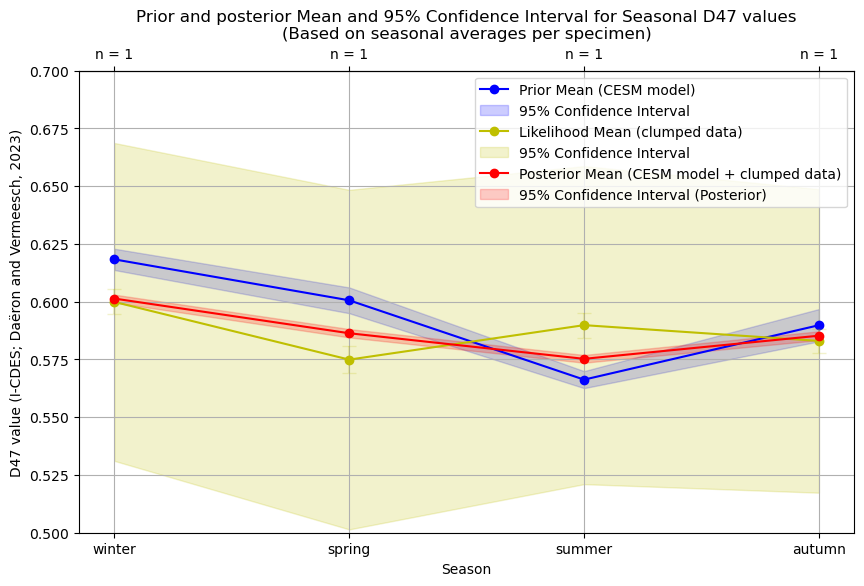

In [145]:
# Plot the updated seasonal posterior
std_post_D47_seasonal_aggregated = np.sqrt(np.diag(cov_post_D47_seasonal_aggregated))
std_prior_D47_seasonal_original = np.sqrt(np.diag(cov_prior_D47_seasonal_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_D47_seasonal_original, label = 'Prior Mean (CESM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_original / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonal_aggregated, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonal_aggregated - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated) * std_likelihood_seasonal_aggregated / np.sqrt(n_update_seasonal_aggregated),
    mu_likelihood_seasonal_aggregated + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated) * std_likelihood_seasonal_aggregated / np.sqrt(n_update_seasonal_aggregated), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in Lutetian_seasonally_aggregated_data_dict: # Loop over measurements
    plt.plot(measurement["season_score"] + 1, measurement["D47_mean"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["season_score"] + 1, measurement["D47_mean"], yerr = measurement["D47_se"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal_aggregated])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_post_D47_seasonal_aggregated, label = 'Posterior Mean (CESM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_post_D47_seasonal_aggregated - stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated + n_models_seasonal)) * std_post_D47_seasonal_aggregated / np.sqrt(n_update_seasonal_aggregated + n_models_seasonal),
    mu_post_D47_seasonal_aggregated + stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated + n_models_seasonal)) * std_post_D47_seasonal_aggregated / np.sqrt(n_update_seasonal_aggregated + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal D47 values\n(Based on seasonal averages per specimen)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.5, 0.7)
plt.legend()
plt.grid(True)
plt.show()

## Update seasonal prior with individual datapoints
* Aggregate data and model outcomes in 4 seasons based on individual D47 datapoints
* No sclero-dating uncertainty
* Treat each D47 datapoint as an individual datapoint

In [146]:
# Apply Kalman function to update the prior with seasonal data including updating the precipitation estimates
# Update the seasonal D47 and precipitation prior with all measurements using block updating
seasonal_data = {} # Keep track of datapoints per season
n_update_seasonal = mu_prior_D47_seasonal * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonal = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonal = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonal = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonal = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Update the prior with seasonal data using the Kalman filter in block updating form
mu_post_seasonal, cov_post_seasonal = kalman_update_block(
    mu_prior_seasonal_combined,
    cov_prior_seasonal_combined,
    Z_samples,
    R_samples,
    H_seasonal
)

# Extract the updated D47 and precipitation values from the combined state vector
mu_post_D47_seasonal = mu_post_seasonal[:len(mu_prior_D47_seasonal)]
mu_post_prec_seasonal = mu_post_seasonal[len(mu_prior_D47_seasonal):]

# Extract the updated covariance matrices for D47 and prec
cov_post_D47_seasonal = cov_post_seasonal[:len(mu_prior_D47_seasonal), :len(mu_prior_D47_seasonal)]
cov_post_prec_seasonal = cov_post_seasonal[len(mu_prior_D47_seasonal):, len(mu_prior_D47_seasonal):]

for measurement in Lutetian_D47_data_dict: # Loop over measurements    
    # Track and update likelihood statistics
    weighted_sum_seasonal, effective_weights_total_seasonal, n_update_seasonal, seasonal_data = likelihood_statistics(
        weighted_sum_seasonal,
        effective_weights_total_seasonal,
        n_update_seasonal,
        seasonal_data,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "Season_err",
        Variable_name = "D47_final",
        Variable_name_SD = "D47_SD"
    )

# Normalize the weighted_sum_seasonal to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonal to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_seasonal)):
    if effective_weights_total_seasonal[i] is not None and effective_weights_total_seasonal[i] != 0:
        mu_likelihood_seasonal[i] = weighted_sum_seasonal[i] / effective_weights_total_seasonal[i]
        std_likelihood_seasonal[i] = np.sqrt(1 / effective_weights_total_seasonal[i])

    print(f"Month: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_seasonal[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_seasonal[i]}")
    print(f"Number of Data Points: {n_update_seasonal[i]}\n")

print("Original Prior Mean D47 Seasonal:\n", mu_prior_D47_seasonal_original)
print("Original Prior Standard Deviation D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_D47_seasonal_original)))
print("Updated Prior Mean D47 Seasonal:\n", mu_post_D47_seasonal)
print("Updated Prior Standard Deviation D47 Seasonal:\n", np.sqrt(np.diag(cov_post_D47_seasonal)))
print("Original Prior Mean seasonal precipitation:\n", mu_prior_prec_seasonal_original)
print("Original Prior Standard Deviation seasonal precipitation:\n", np.sqrt(np.diag(cov_prior_prec_seasonal_original)))
print("Updated Prior Mean seasonal precipitation:\n", mu_post_prec_seasonal)
print("Updated Prior Standard Deviation seasonal precipitation:\n", np.sqrt(np.diag(cov_post_prec_seasonal)))

Shape of cov_prior: (8, 8)
Shape of H: (168, 8)
Shape of R: (168, 168)
Shape of mu_prior: (8,)
Shape of Z: (168, 1)
Shape of K: (8, 168)
Shape of Y_hat: (168,)
Shape of innovation: (168, 1)
Shape of kalman_gain: (8, 1)
Likelihood statistics:
Month: 1
Weighted Average D47: 0.5993461538461538
Aggregated Uncertainty (D47_sd): 0.005687367919007337
Number of Data Points: 26.0

Month: 2
Weighted Average D47: 0.5812750000000003
Aggregated Uncertainty (D47_sd): 0.004585302607244152
Number of Data Points: 40.0

Month: 3
Weighted Average D47: 0.5897903225806456
Aggregated Uncertainty (D47_sd): 0.003683003683005526
Number of Data Points: 62.0

Month: 4
Weighted Average D47: 0.5846500000000002
Aggregated Uncertainty (D47_sd): 0.004585302607244152
Number of Data Points: 40.0

Original Prior Mean D47 Seasonal:
 [0.61833332 0.60060654 0.56627243 0.58983039]
Original Prior Standard Deviation D47 Seasonal:
 [0.01118452 0.01354114 0.00895396 0.01698911]
Updated Prior Mean D47 Seasonal:
 [0.60201744 0.58

C:\Users\nwi213\AppData\Local\Temp\ipykernel_21416\470237694.py:62: RuntimeWarning: invalid value encountered in sqrt
  print("Updated Prior Standard Deviation seasonal precipitation:\n", np.sqrt(np.diag(cov_post_prec_seasonal)))


### Plot seasonal posterior in D47 domain

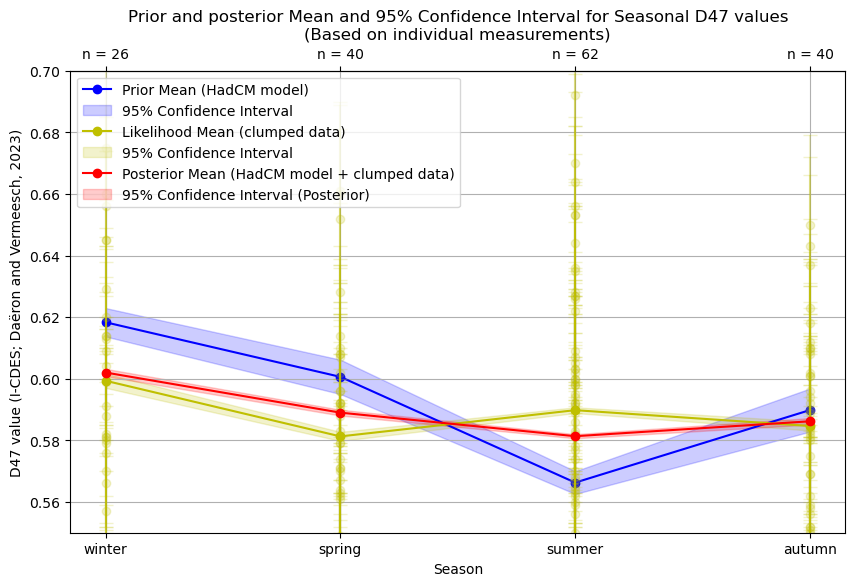

In [147]:
# Plot the updated seasonal posterior
std_post_D47_seasonal = np.sqrt(np.diag(cov_post_D47_seasonal))
std_prior_D47_seasonal_original = np.sqrt(np.diag(cov_prior_D47_seasonal_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_D47_seasonal_original, label = 'Prior Mean (HadCM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_original / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonal, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonal - stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal / np.sqrt(n_update_seasonal),
    mu_likelihood_seasonal + stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal / np.sqrt(n_update_seasonal), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in Lutetian_D47_data_dict: # Loop over measurements
    plt.plot(measurement["season_score"] + 1, measurement["D47_final"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["season_score"] + 1, measurement["D47_final"], yerr = measurement["D47_SD"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_post_D47_seasonal, label = 'Posterior Mean (HadCM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_post_D47_seasonal - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_D47_seasonal / np.sqrt(n_update_seasonal + n_models_seasonal),
    mu_post_D47_seasonal + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_D47_seasonal / np.sqrt(n_update_seasonal + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal D47 values\n(Based on individual measurements)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

## Update monthly prior with individual datapoints
* Aggregate data and model outcomes in 12 seasons based on individual D47 datapoints
* No sclero-dating uncertainty
* Treat each D47 datapoint as an individual datapoint

In [148]:
# Apply Kalman function to update the prior with monthly data including updating the precipitation estimates
# Update the monthly D47 and precipitation prior with all measurements using block updating
monthly_data = {} # Keep track of datapoints per season
n_update_monthly = mu_prior_D47_monthly * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_monthly = mu_prior_D47_monthly * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_monthly = mu_prior_D47_monthly * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_monthly = mu_prior_D47_monthly * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_monthly = mu_prior_D47_monthly * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Update the prior with monthly data using the Kalman filter in block updating form
mu_post_monthly, cov_post_monthly = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_samples,
    R_samples,
    H_monthly
)

# Extract the updated D47 and precipitation values from the combined state vector
mu_post_D47_monthly = mu_post_monthly[:len(mu_prior_D47_monthly)]
mu_post_prec_monthly = mu_post_monthly[len(mu_prior_D47_monthly):]

# Extract the updated covariance matrices for D47 and prec
cov_post_D47_monthly = cov_post_monthly[:len(mu_prior_D47_monthly), :len(mu_prior_D47_monthly)]
cov_post_prec_monthly = cov_post_monthly[len(mu_prior_D47_monthly):, len(mu_prior_D47_monthly):]

for measurement in Lutetian_D47_data_dict: # Loop over measurements    
    # Track and update likelihood statistics
    weighted_sum_monthly, effective_weights_total_monthly, n_update_monthly, monthly_data = likelihood_statistics(
        weighted_sum_monthly,
        effective_weights_total_monthly,
        n_update_monthly,
        monthly_data,
        measurement,
        timestamp = "month_score",
        timestamp_sd = "Month_err",
        Variable_name = "D47_final",
        Variable_name_SD = "D47_SD"
    )

# Normalize the weighted_sum_monthly to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_monthly to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_monthly)):
    if effective_weights_total_monthly[i] is not None and effective_weights_total_monthly[i] != 0:
        mu_likelihood_monthly[i] = weighted_sum_monthly[i] / effective_weights_total_monthly[i]
        std_likelihood_monthly[i] = np.sqrt(1 / effective_weights_total_monthly[i])

    print(f"Month: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_monthly[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_monthly[i]}")
    print(f"Number of Data Points: {n_update_monthly[i]}\n")

print("Original Prior Mean D47 monthly:\n", mu_prior_D47_monthly_original)
print("Original Prior Standard Deviation D47 monthly:\n", np.sqrt(np.diag(cov_prior_D47_monthly_original)))
print("Updated Prior Mean D47 monthly:\n", mu_post_D47_monthly)
print("Updated Prior Standard Deviation D47 monthly:\n", np.sqrt(np.diag(cov_post_D47_monthly)))
print("Original Prior Mean monthly precipitation:\n", mu_prior_prec_monthly_original)
print("Original Prior Standard Deviation monthly precipitation:\n", np.sqrt(np.diag(cov_prior_prec_monthly_original)))
print("Updated Prior Mean monthly precipitation:\n", mu_post_prec_monthly)
print("Updated Prior Standard Deviation monthly precipitation:\n", np.sqrt(np.diag(cov_post_prec_monthly)))

Shape of cov_prior: (24, 24)
Shape of H: (168, 24)
Shape of R: (168, 168)
Shape of mu_prior: (24,)
Shape of Z: (168, 1)
Shape of K: (24, 168)
Shape of Y_hat: (168,)
Shape of innovation: (168, 1)
Shape of kalman_gain: (24, 1)
Likelihood statistics:
Month: 1
Weighted Average D47: 0.6315000000000001
Aggregated Uncertainty (D47_sd): 0.0145
Number of Data Points: 4.0

Month: 2
Weighted Average D47: 0.5964285714285713
Aggregated Uncertainty (D47_sd): 0.01096096971726759
Number of Data Points: 7.0

Month: 3
Weighted Average D47: 0.6064999999999998
Aggregated Uncertainty (D47_sd): 0.01025304832720494
Number of Data Points: 8.0

Month: 4
Weighted Average D47: 0.0
Aggregated Uncertainty (D47_sd): 0.0
Number of Data Points: 0.0

Month: 5
Weighted Average D47: 0.5749687500000001
Aggregated Uncertainty (D47_sd): 0.0051265241636024705
Number of Data Points: 32.0

Month: 6
Weighted Average D47: 0.5925624999999998
Aggregated Uncertainty (D47_sd): 0.0072499999999999995
Number of Data Points: 16.0

Mont

C:\Users\nwi213\AppData\Local\Temp\ipykernel_21416\280848438.py:62: RuntimeWarning: invalid value encountered in sqrt
  print("Updated Prior Standard Deviation monthly precipitation:\n", np.sqrt(np.diag(cov_post_prec_monthly)))


### Plot monthly posterior in D47 domain

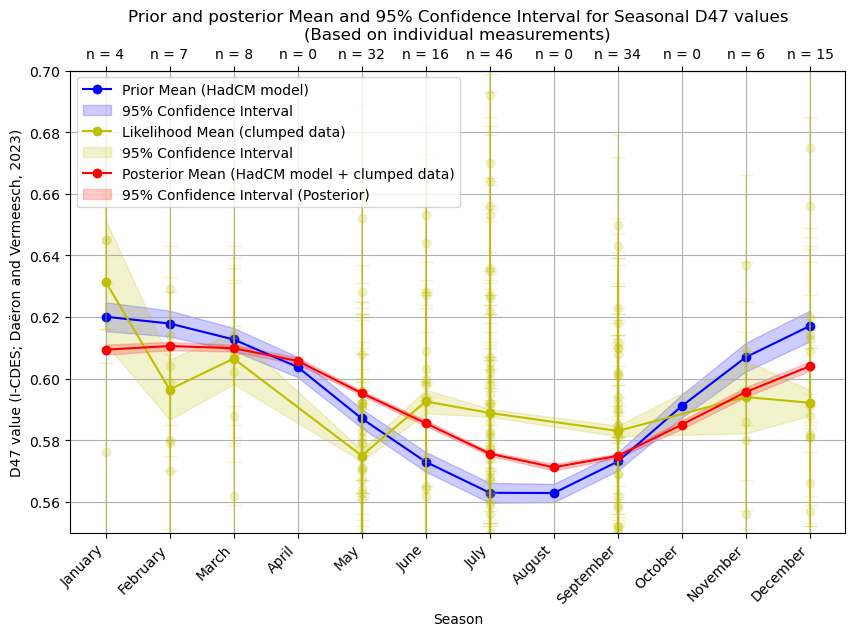

In [149]:
# Plot the updated seasonal posterior
std_post_D47_monthly = np.sqrt(np.diag(cov_post_D47_monthly))
std_prior_D47_monthly_original = np.sqrt(np.diag(cov_prior_D47_monthly_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_D47_monthly_original, label = 'Prior Mean (HadCM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_D47_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_original / np.sqrt(n_models_monthly),
    mu_prior_D47_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_original / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
valid_bins = mu_likelihood_monthly != 0 # Filter out bins where mu_likelihood_monthly is zero because these have no data
plt.plot(months_scale[valid_bins], mu_likelihood_monthly[valid_bins], label='Likelihood Mean (clumped data)', color='y', marker='o') # Add likelihood mean for valid bins

# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation) for valid bins
plt.fill_between(months_scale[valid_bins],
    mu_likelihood_monthly[valid_bins] - stats.t.ppf(1 - 0.025, n_update_monthly[valid_bins]) * std_likelihood_monthly[valid_bins] / np.sqrt(n_update_monthly[valid_bins]),
    mu_likelihood_monthly[valid_bins] + stats.t.ppf(1 - 0.025, n_update_monthly[valid_bins]) * std_likelihood_monthly[valid_bins] / np.sqrt(n_update_monthly[valid_bins]),
    color='y',
    alpha=0.2,
    label='95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in Lutetian_D47_data_dict: # Loop over measurements
    plt.plot(measurement["month_score"] + 1, measurement["D47_final"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["month_score"] + 1, measurement["D47_final"], yerr = measurement["D47_SD"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_post_D47_monthly, label = 'Posterior Mean (HadCM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_post_D47_monthly - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_post_D47_monthly / np.sqrt(n_update_monthly + n_models_monthly),
    mu_post_D47_monthly + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_post_D47_monthly / np.sqrt(n_update_monthly + n_models_monthly),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal D47 values\n(Based on individual measurements)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

# POSTERIORS IN SAT AND precipitation domain

## Updated seasonal prior in SAT and precipitation domain
* Data and model outcomes aggregated in 4 seasons
* No sclero-dating uncertainty
* D47 Data aggregated per specimen and per season

### Convert seasonal prior, likelihood and posterior to temperature and plot

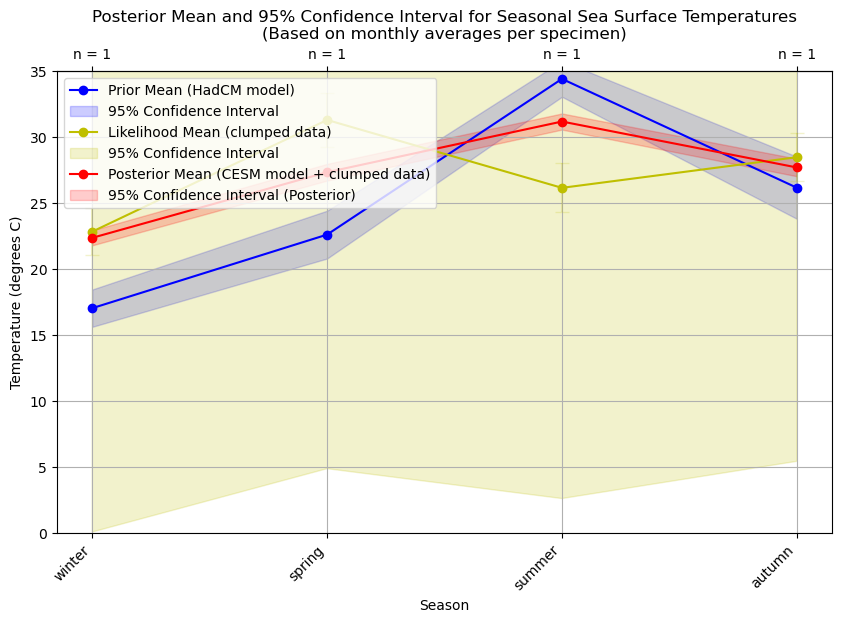

In [150]:
# Convert prior D47 to temp
mu_prior_D47_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_prior_D47_seasonal_original, sD47 = cov_prior_D47_seasonal_original, return_covar = True)[0]
cov_prior_D47_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_prior_D47_seasonal_original, sD47 = cov_prior_D47_seasonal_original, return_covar = True)[1]
# Convert likelihood D47 to temp
mu_likelihood_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal_aggregated, sD47 = std_likelihood_seasonal_aggregated, return_covar = True)[0]
cov_likelihood_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal_aggregated, sD47 = std_likelihood_seasonal_aggregated, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_D47_seasonal_aggregated, sD47 = cov_post_D47_seasonal_aggregated, return_covar = True)[0]
cov_posterior_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_D47_seasonal_aggregated, sD47 = cov_post_D47_seasonal_aggregated, return_covar = True)[1]

# Plot in temperature domain
std_prior_D47_seasonal_aggregated_T = np.sqrt(np.diag(cov_prior_D47_seasonal_aggregated_T))
std_likelihood_seasonal_aggregated_T = np.sqrt(np.diag(cov_likelihood_seasonal_aggregated_T))
std_posterior_seasonal_aggregated_T = np.sqrt(np.diag(cov_posterior_seasonal_aggregated_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_D47_seasonal_aggregated_T, label = 'Prior Mean (HadCM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_aggregated_T / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_aggregated_T / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonal_aggregated_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated) * std_likelihood_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated),
    mu_likelihood_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated) * std_likelihood_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in Lutetian_seasonally_aggregated_data_dict: # Loop over measurements
    plt.plot(measurement["season_score"] + 1, D47c.OGLS23.T47(D47 = measurement["D47_mean"], sD47 = measurement["D47_se"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["season_score"] + 1, D47c.OGLS23.T47(D47 = measurement["D47_mean"], sD47 = measurement["D47_se"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47_mean"], sD47 = measurement["D47_se"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal_aggregated])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_posterior_seasonal_aggregated_T, label = 'Posterior Mean (CESM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_posterior_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated + n_models_seasonal)) * std_posterior_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated + n_models_seasonal),
    mu_posterior_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated + n_models_seasonal)) * std_posterior_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Sea Surface Temperatures\n(Based on monthly averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot precipitation prior and posterior

C:\Users\nwi213\AppData\Local\Temp\ipykernel_21416\2277564928.py:3: RuntimeWarning: invalid value encountered in sqrt
  std_posterior_prec_seasonal_aggregated = np.nan_to_num(np.sqrt(np.diag(cov_post_prec_seasonal_aggregated)))


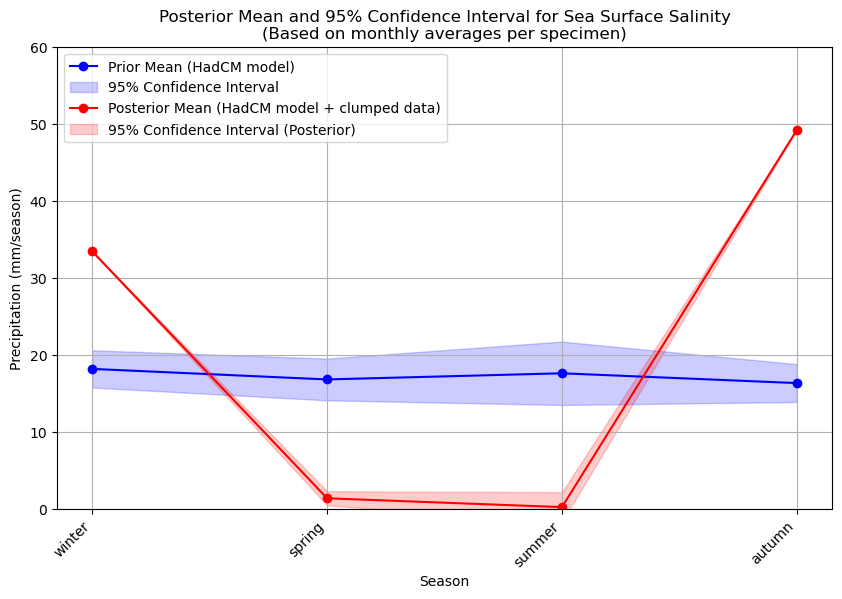

In [151]:
# Plot in temperature domain, set nan values to zero
std_prior_prec_seasonal = np.nan_to_num(np.sqrt(np.diag(cov_prior_prec_seasonal_original)))
std_posterior_prec_seasonal_aggregated = np.nan_to_num(np.sqrt(np.diag(cov_post_prec_seasonal_aggregated)))

# Initiate plot
plt.figure(figsize=(10, 6))

# PRIOR
# Add prior mean in mm/season
plt.plot(seasons_scale, mu_prior_prec_seasonal_mm, label='Prior Mean (HadCM model)', color='b', marker='o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_prec_seasonal_mm - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_prec_seasonal_mm / np.sqrt(n_models_seasonal),
    mu_prior_prec_seasonal_mm + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_prec_seasonal_mm / np.sqrt(n_models_seasonal),
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# POSTERIOR
# Add posterior mean in mm/season
mu_post_prec_seasonal_mm = mu_post_prec_seasonal_aggregated * mm_per_day_to_mm_per_season
std_post_prec_seasonal_mm = std_posterior_prec_seasonal_aggregated * mm_per_day_to_mm_per_season

plt.plot(seasons_scale, mu_post_prec_seasonal_mm, label='Posterior Mean (HadCM model + clumped data)', color='r', marker='o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_post_prec_seasonal_mm - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_prec_seasonal_mm / np.sqrt(n_update_seasonal + n_models_seasonal),
    mu_post_prec_seasonal_mm + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_prec_seasonal_mm / np.sqrt(n_update_seasonal + n_models_seasonal),
    color='r',
    alpha=0.2,
    label='95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Sea Surface Salinity\n(Based on monthly averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Precipitation (mm/season)')
plt.ylim(0, 60)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SAT and precipitation and posterior

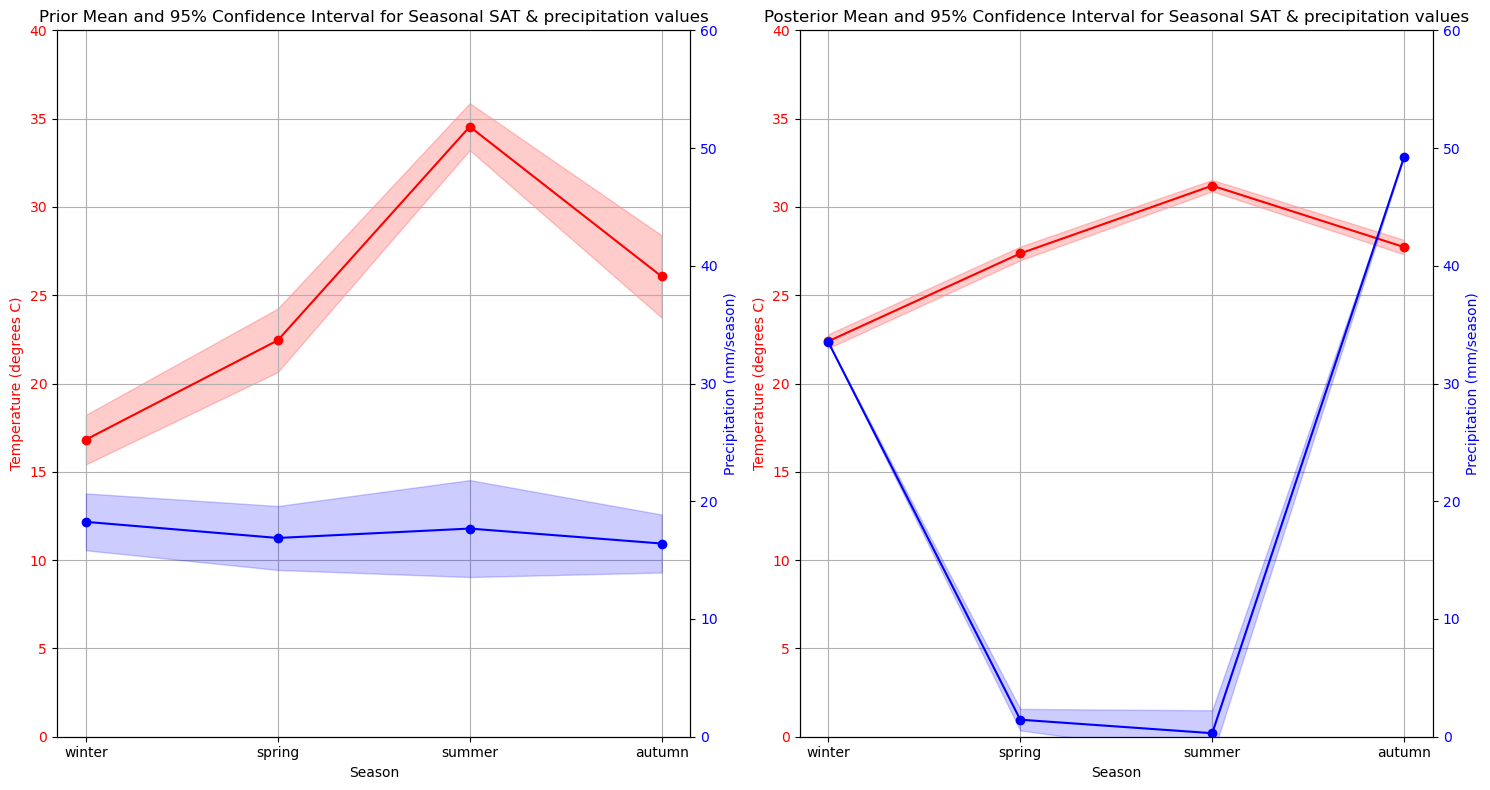

In [152]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot the prior distribution and confidence envelopes per season for SAT & precipitation
axes[0].plot(seasons_scale, mu_prior_SAT_seasonal, label='Prior SAT Mean', marker='o', color='r')
axes[0].fill_between(seasons_scale,
                     mu_prior_SAT_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
                     mu_prior_SAT_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
                     alpha=0.2, color='r', label='95% Confidence Interval (SAT)')
axes[0].set_xticks(seasons_scale)
axes[0].set_xticklabels(seasons)
axes[0].set_title('Prior Mean and 95% Confidence Interval for Seasonal SAT & precipitation values')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Temperature (degrees C)', color='r')
axes[0].tick_params(axis='y', labelcolor='r')
axes[0].grid(True)
# Add a second y-axis for precipitation in mm/season
ax0_prec = axes[0].twinx()
ax0_prec.plot(seasons_scale, mu_prior_prec_seasonal_mm, label='Prior precipitation Mean', marker='o', color='b')
ax0_prec.fill_between(seasons_scale,
                      mu_prior_prec_seasonal_mm - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_prec_seasonal_mm / np.sqrt(n_models_seasonal),
                      mu_prior_prec_seasonal_mm + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_prec_seasonal_mm / np.sqrt(n_models_seasonal),
                      alpha=0.2, color='b', label='95% Confidence Interval (precipitation)')
ax0_prec.set_ylabel('Precipitation (mm/season)', color='b')
ax0_prec.tick_params(axis='y', labelcolor='b')

# Plot the posterior distribution and confidence envelopes per season for SAT & precipitation
axes[1].plot(seasons_scale, mu_posterior_seasonal_aggregated_T, label='Posterior SAT Mean', marker='o', color='r')
axes[1].fill_between(seasons_scale,
                     mu_posterior_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_posterior_seasonal_aggregated_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     mu_posterior_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_posterior_seasonal_aggregated_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     alpha=0.2, color='r', label='95% Confidence Interval (SAT)')
axes[1].set_xticks(seasons_scale)
axes[1].set_xticklabels(seasons)
axes[1].set_title('Posterior Mean and 95% Confidence Interval for Seasonal SAT & precipitation values')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Temperature (degrees C)', color='r')
axes[1].tick_params(axis='y', labelcolor='r')
axes[1].grid(True)

# Add a second y-axis for precipitation in mm/season
ax1_prec = axes[1].twinx()
ax1_prec.plot(seasons_scale, mu_post_prec_seasonal_mm, label='Posterior precipitation Mean', marker='o', color='b')
ax1_prec.fill_between(seasons_scale,
                      mu_post_prec_seasonal_mm - stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_prec_seasonal_mm / np.sqrt(n_update_seasonal + n_models_seasonal),
                      mu_post_prec_seasonal_mm + stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_prec_seasonal_mm / np.sqrt(n_update_seasonal + n_models_seasonal),
                      alpha=0.2, color='b', label='95% Confidence Interval (precipitation)')
ax1_prec.set_ylabel('Precipitation (mm/season)', color='b')
ax1_prec.tick_params(axis='y', labelcolor='b')

# Set equal limits for temperature and precipitation axes
axes[0].set_ylim(0, 40)
ax0_prec.set_ylim(0, 60)
axes[1].set_ylim(0, 40)
ax1_prec.set_ylim(0, 60)

plt.tight_layout()
plt.show()

## Updated seasonal prior in SAT and precipitation domain
* Data and model outcomes aggregated in 4 seasons
* No sclero-dating uncertainty
* D47 data aggregated as individual datapoints

### Convert seasonal prior, likelihood and posterior to temperature and plot

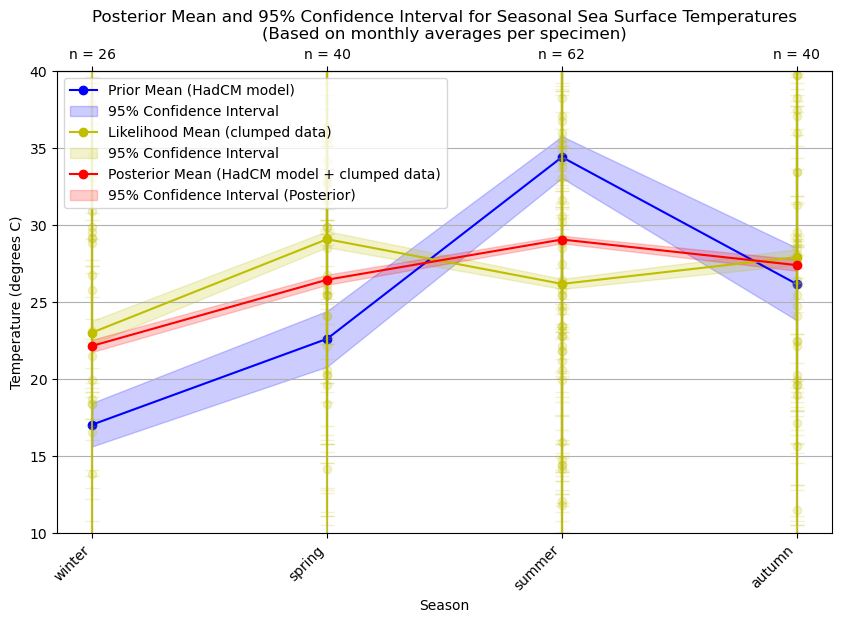

In [153]:
# Convert prior D47 to temp
mu_prior_D47_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_D47_seasonal_original, sD47 = cov_prior_D47_seasonal_original, return_covar = True)[0]
cov_prior_D47_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_D47_seasonal_original, sD47 = cov_prior_D47_seasonal_original, return_covar = True)[1]
# Convert likelihood D47 to temp
mu_likelihood_seasonal_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal, sD47 = std_likelihood_seasonal, return_covar = True)[0]
cov_likelihood_seasonal_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal, sD47 = std_likelihood_seasonal, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_seasonal_T = D47c.OGLS23.T47(D47 = mu_post_D47_seasonal, sD47 = cov_post_D47_seasonal, return_covar = True)[0]
cov_posterior_seasonal_T = D47c.OGLS23.T47(D47 = mu_post_D47_seasonal, sD47 = cov_post_D47_seasonal, return_covar = True)[1]

# Plot in temperature domain
std_prior_D47_seasonal_T = np.sqrt(np.diag(cov_prior_D47_seasonal_T))
std_likelihood_seasonal_T = np.sqrt(np.diag(cov_likelihood_seasonal_T))
std_posterior_seasonal_T = np.sqrt(np.diag(cov_posterior_seasonal_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_D47_seasonal_T, label = 'Prior Mean (HadCM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_T / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonal_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonal_T - stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal_T / np.sqrt(n_update_seasonal),
    mu_likelihood_seasonal_T + stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal_T / np.sqrt(n_update_seasonal), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in Lutetian_D47_data_dict: # Loop over measurements
    plt.plot(measurement["season_score"] + 1, D47c.OGLS23.T47(D47 = measurement["D47_final"], sD47 = measurement["D47_SD"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["season_score"] + 1, D47c.OGLS23.T47(D47 = measurement["D47_final"], sD47 = measurement["D47_SD"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47_final"], sD47 = measurement["D47_SD"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_posterior_seasonal_T, label = 'Posterior Mean (HadCM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_posterior_seasonal_T - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_posterior_seasonal_T / np.sqrt(n_update_seasonal + n_models_seasonal),
    mu_posterior_seasonal_T + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_posterior_seasonal_T / np.sqrt(n_update_seasonal + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Sea Surface Temperatures\n(Based on monthly averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(10, 40)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot precipitation prior and posterior

C:\Users\nwi213\AppData\Local\Temp\ipykernel_21416\1878817324.py:3: RuntimeWarning: invalid value encountered in sqrt
  std_posterior_prec_seasonal = np.nan_to_num(np.sqrt(np.diag(cov_post_prec_seasonal)))


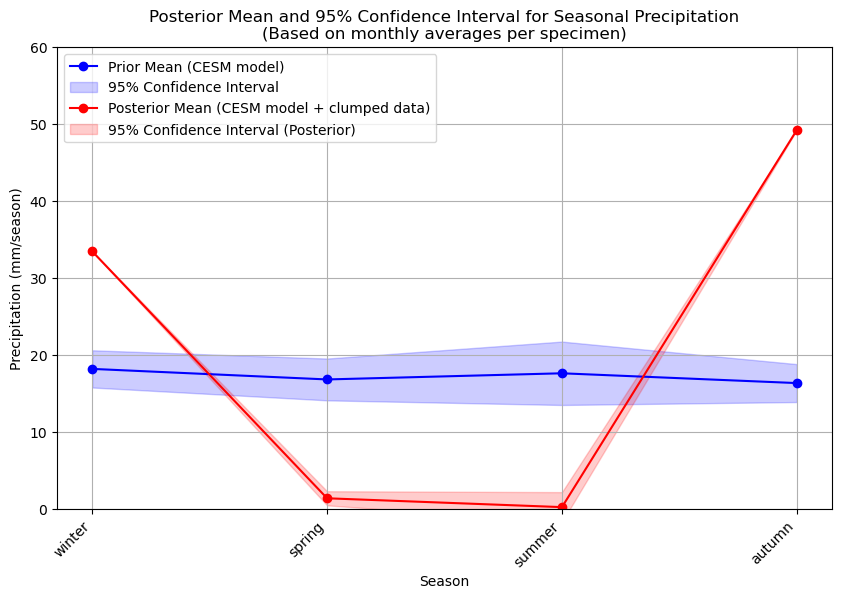

In [154]:
# Plot in temperature domain, set nan values to zero
std_prior_prec_seasonal = np.nan_to_num(np.sqrt(np.diag(cov_prior_prec_seasonal_original)))
std_posterior_prec_seasonal = np.nan_to_num(np.sqrt(np.diag(cov_post_prec_seasonal)))

# Initiate plot
plt.figure(figsize = (10, 6))
# PRIOR
# Add prior mean in mm/season
plt.plot(seasons_scale, mu_prior_prec_seasonal_mm, label='Prior Mean (CESM model)', color='b', marker='o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_prec_seasonal_mm - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_prec_seasonal_mm / np.sqrt(n_models_seasonal),
    mu_prior_prec_seasonal_mm + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_prec_seasonal_mm / np.sqrt(n_models_seasonal),
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# POSTERIOR
# Add posterior mean in mm/season
plt.plot(seasons_scale, mu_post_prec_seasonal_mm, label='Posterior Mean (CESM model + clumped data)', color='r', marker='o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_post_prec_seasonal_mm - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_prec_seasonal_mm / np.sqrt(n_update_seasonal + n_models_seasonal),
    mu_post_prec_seasonal_mm + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_prec_seasonal_mm / np.sqrt(n_update_seasonal + n_models_seasonal),
    color='r',
    alpha=0.2,
    label='95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation=45, ha="right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Precipitation\n(Based on monthly averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Precipitation (mm/season)')
plt.ylim(0, 60)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### Plot SAT and precipitation posterior

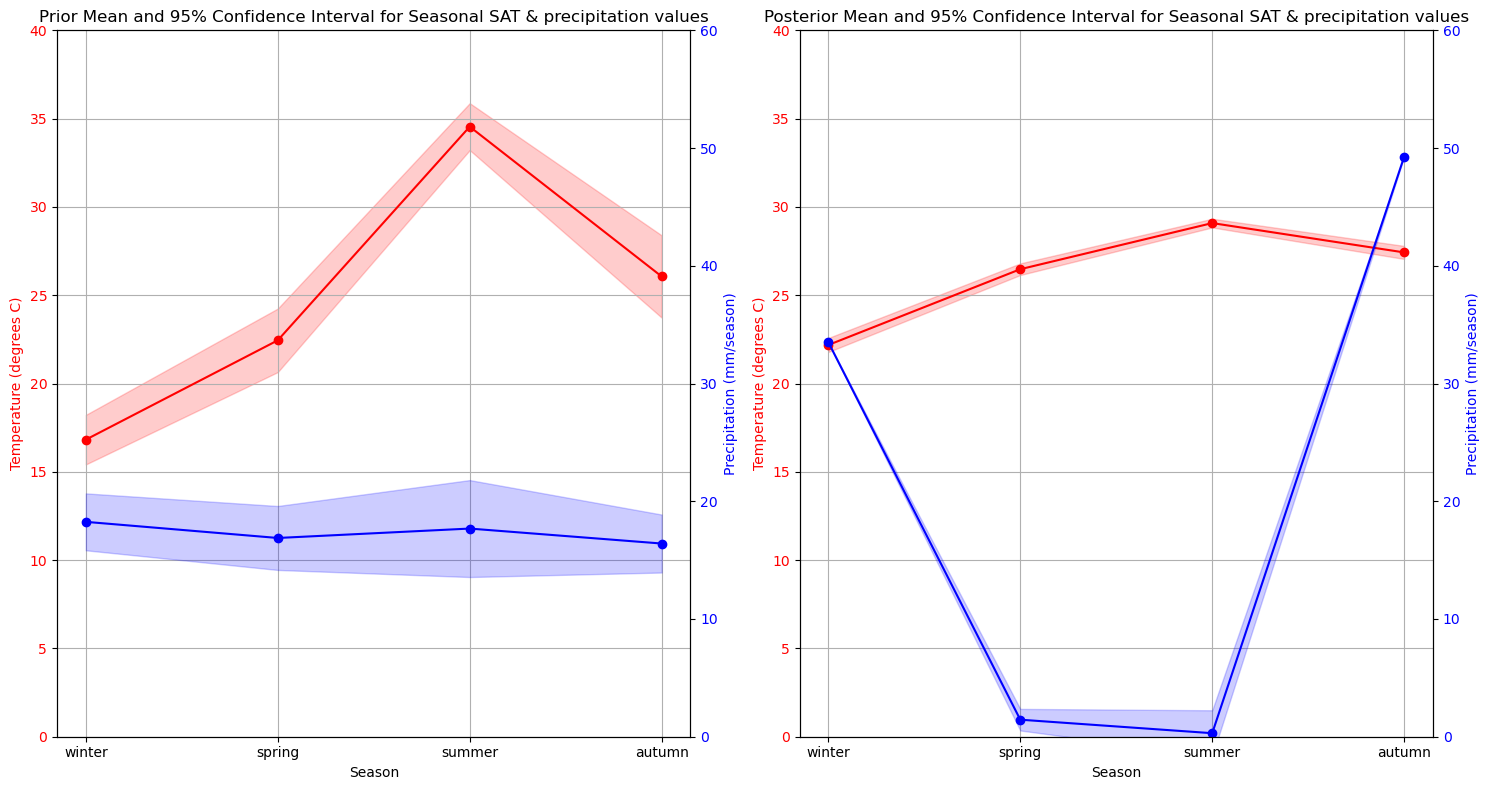

In [155]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot the prior distribution and confidence envelopes per season for SAT & prec
axes[0].plot(seasons_scale, mu_prior_SAT_seasonal, label='Prior SAT Mean', marker='o', color='r')
axes[0].fill_between(seasons_scale,
                     mu_prior_SAT_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
                     mu_prior_SAT_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
                     alpha=0.2, color='r', label='95% Confidence Interval (SAT)')
axes[0].set_xticks(seasons_scale)
axes[0].set_xticklabels(seasons)
axes[0].set_title('Prior Mean and 95% Confidence Interval for Seasonal SAT & precipitation values')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Temperature (degrees C)', color='r')
axes[0].tick_params(axis='y', labelcolor='r')
axes[0].grid(True)

# Add a second y-axis for precipitation in mm per season
ax0_prec = axes[0].twinx()
ax0_prec.plot(seasons_scale, mu_prior_prec_seasonal_mm, label='Prior precipitation Mean', marker='o', color='b')
ax0_prec.fill_between(seasons_scale,
                      mu_prior_prec_seasonal_mm - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_prec_seasonal_mm / np.sqrt(n_models_seasonal),
                      mu_prior_prec_seasonal_mm + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_prec_seasonal_mm / np.sqrt(n_models_seasonal),
                      alpha=0.2, color='b', label='95% Confidence Interval (precipitation)')
ax0_prec.set_ylabel('Precipitation (mm/season)', color='b')
ax0_prec.tick_params(axis='y', labelcolor='b')

# Plot the posterior distribution and confidence envelopes per season for SAT & prec
axes[1].plot(seasons_scale, mu_posterior_seasonal_T, label='Posterior SAT Mean', marker='o', color='r')
axes[1].fill_between(seasons_scale,
                     mu_posterior_seasonal_T - stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_posterior_seasonal_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     mu_posterior_seasonal_T + stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_posterior_seasonal_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     alpha=0.2, color='r', label='95% Confidence Interval (SAT)')
axes[1].set_xticks(seasons_scale)
axes[1].set_xticklabels(seasons)
axes[1].set_title('Posterior Mean and 95% Confidence Interval for Seasonal SAT & precipitation values')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Temperature (degrees C)', color='r')
axes[1].tick_params(axis='y', labelcolor='r')
axes[1].grid(True)

# Add a second y-axis for precipitation in mm per season
ax1_prec = axes[1].twinx()
ax1_prec.plot(seasons_scale, mu_post_prec_seasonal_mm, label='Posterior precipitation Mean', marker='o', color='b')
ax1_prec.fill_between(seasons_scale,
                      mu_post_prec_seasonal_mm - stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_prec_seasonal_mm / np.sqrt(n_update_seasonal + n_models_seasonal),
                      mu_post_prec_seasonal_mm + stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_prec_seasonal_mm / np.sqrt(n_update_seasonal + n_models_seasonal),
                      alpha=0.2, color='b', label='95% Confidence Interval (precipitation)')
ax1_prec.set_ylabel('Precipitation (mm/season)', color='b')
ax1_prec.tick_params(axis='y', labelcolor='b')

# Set equal limits for temperature and precipitation axes
axes[0].set_ylim(0, 40)
ax0_prec.set_ylim(0, 60)
axes[1].set_ylim(0, 40)
ax1_prec.set_ylim(0, 60)

plt.tight_layout()
plt.show()

## Updated monthly prior in SAT and precipitation domain
* Data and model outcomes aggregated in 12 months
* No sclero-dating uncertainty
* D47 data aggregated as individual datapoints

### Convert seasonal prior, likelihood and posterior to temperature and plot

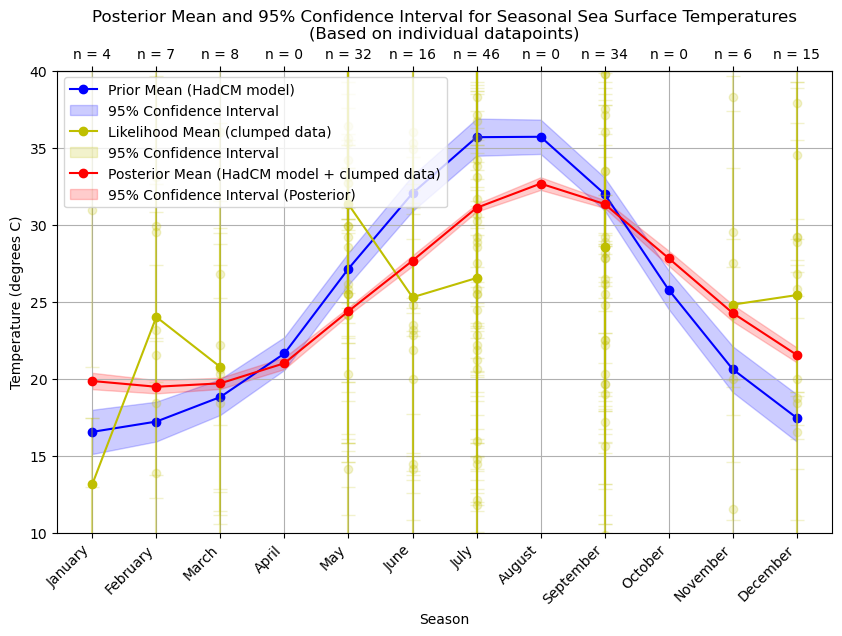

In [156]:
# Convert prior D47 to temp
mu_prior_D47_monthly_T = D47c.OGLS23.T47(D47=mu_prior_D47_monthly_original, sD47=cov_prior_D47_monthly_original, return_covar=True)[0]
cov_prior_D47_monthly_T = D47c.OGLS23.T47(D47=mu_prior_D47_monthly_original, sD47=cov_prior_D47_monthly_original, return_covar=True)[1]

# Convert likelihood D47 to temp, replacing zeroes with NA
mu_likelihood_monthly_with_na = np.where(mu_likelihood_monthly == 0, np.nan, mu_likelihood_monthly)
std_likelihood_monthly_with_na = np.where(std_likelihood_monthly == 0, np.nan, std_likelihood_monthly)
mu_likelihood_monthly_T = D47c.OGLS23.T47(D47=mu_likelihood_monthly_with_na, sD47=std_likelihood_monthly_with_na, return_covar=True)[0]
cov_likelihood_monthly_T = D47c.OGLS23.T47(D47=mu_likelihood_monthly_with_na, sD47=std_likelihood_monthly_with_na, return_covar=True)[1]

# Convert posterior D47 to temp
mu_posterior_monthly_T = D47c.OGLS23.T47(D47=mu_post_D47_monthly, sD47=cov_post_D47_monthly, return_covar=True)[0]
cov_posterior_monthly_T = D47c.OGLS23.T47(D47=mu_post_D47_monthly, sD47=cov_post_D47_monthly, return_covar=True)[1]

# Plot in temperature domain
std_prior_D47_monthly_T = np.sqrt(np.diag(cov_prior_D47_monthly_T))
std_likelihood_monthly_T = np.sqrt(np.diag(cov_likelihood_monthly_T))
std_posterior_monthly_T = np.sqrt(np.diag(cov_posterior_monthly_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_D47_monthly_T, label = 'Prior Mean (HadCM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_D47_monthly_T - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_T / np.sqrt(n_models_monthly),
    mu_prior_D47_monthly_T + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_T / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months_scale, mu_likelihood_monthly_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_likelihood_monthly_T - stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly_T / np.sqrt(n_update_monthly),
    mu_likelihood_monthly_T + stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly_T / np.sqrt(n_update_monthly), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in Lutetian_D47_data_dict: # Loop over measurements
    plt.plot(measurement["month_score"] + 1, D47c.OGLS23.T47(D47 = measurement["D47_final"], sD47 = measurement["D47_SD"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["month_score"] + 1, D47c.OGLS23.T47(D47 = measurement["D47_final"], sD47 = measurement["D47_SD"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47_final"], sD47 = measurement["D47_SD"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_posterior_monthly_T, label = 'Posterior Mean (HadCM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_posterior_monthly_T - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_posterior_monthly_T / np.sqrt(n_update_monthly + n_models_monthly),
    mu_posterior_monthly_T + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_posterior_monthly_T / np.sqrt(n_update_monthly + n_models_monthly),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Sea Surface Temperatures\n(Based on individual datapoints)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(10, 40)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot precipitation prior and posterior

C:\Users\nwi213\AppData\Local\Temp\ipykernel_21416\1737634915.py:3: RuntimeWarning: invalid value encountered in sqrt
  std_posterior_prec_monthly = np.nan_to_num(np.sqrt(np.diag(cov_post_prec_monthly)))


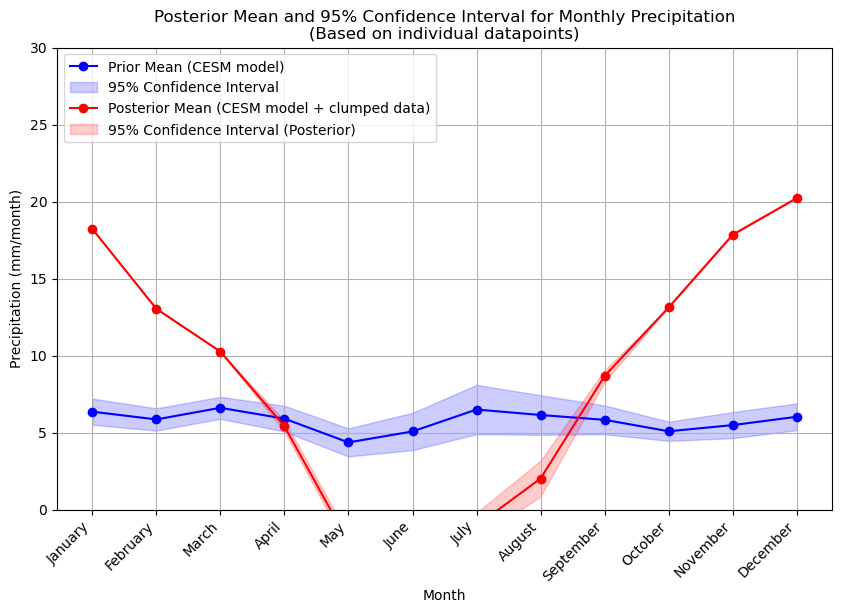

In [161]:
# Plot in temperature domain, set nan values to zero
std_prior_prec_monthly = np.nan_to_num(np.sqrt(np.diag(cov_prior_prec_monthly_original)))
std_posterior_prec_monthly = np.nan_to_num(np.sqrt(np.diag(cov_post_prec_monthly)))

# Initiate plot
plt.figure(figsize=(10, 6))

# PRIOR
# Add prior mean in mm/month
mu_prior_prec_monthly_mm = mu_prior_prec_monthly * mm_per_day_to_mm_per_month
std_prior_prec_monthly_mm = std_prior_prec_monthly * mm_per_day_to_mm_per_month

plt.plot(months_scale, mu_prior_prec_monthly_mm, label='Prior Mean (CESM model)', color='b', marker='o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_prec_monthly_mm - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_prec_monthly_mm / np.sqrt(n_models_monthly),
    mu_prior_prec_monthly_mm + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_prec_monthly_mm / np.sqrt(n_models_monthly),
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# POSTERIOR
# Add posterior mean in mm/month
mu_post_prec_monthly_mm = mu_post_prec_monthly * mm_per_day_to_mm_per_month
std_post_prec_monthly_mm = std_posterior_prec_monthly * mm_per_day_to_mm_per_month

plt.plot(months_scale, mu_post_prec_monthly_mm, label='Posterior Mean (CESM model + clumped data)', color='r', marker='o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_post_prec_monthly_mm - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_post_prec_monthly_mm / np.sqrt(n_update_monthly + n_models_monthly),
    mu_post_prec_monthly_mm + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_post_prec_monthly_mm / np.sqrt(n_update_monthly + n_models_monthly),
    color='r',
    alpha=0.2,
    label='95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation=45, ha="right")
plt.title('Posterior Mean and 95% Confidence Interval for Monthly Precipitation\n(Based on individual datapoints)')
plt.xlabel('Month')
plt.ylabel('Precipitation (mm/month)')
plt.ylim(0, 30)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### Plot SAT and precipitation and posterior

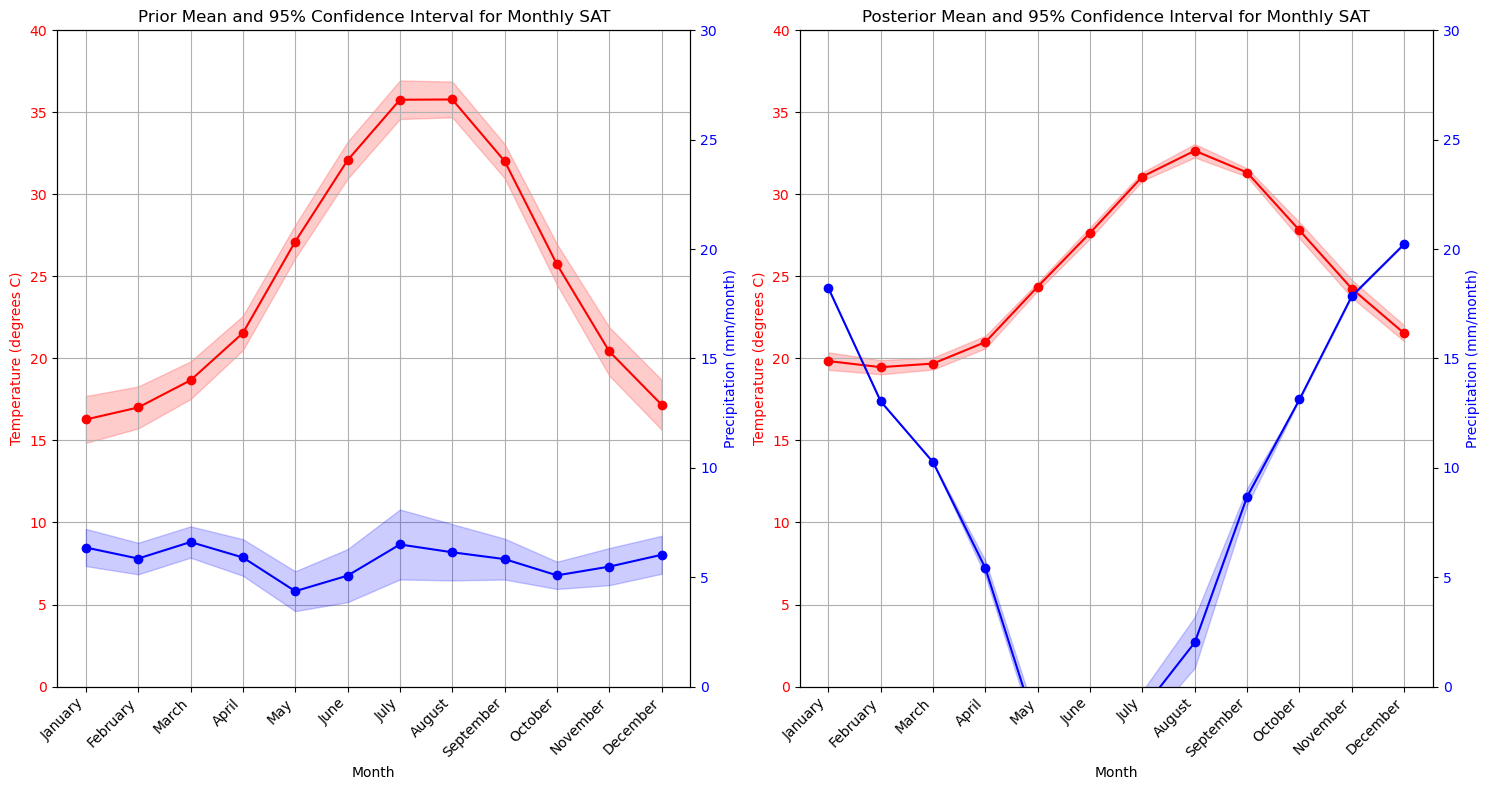

In [162]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot the prior distribution and confidence envelopes per month for SAT & precipitation
axes[0].plot(months_scale, mu_prior_SAT_monthly, label='Prior SAT Mean', marker='o', color='r')
axes[0].fill_between(months_scale,
                     mu_prior_SAT_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
                     mu_prior_SAT_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
                     alpha=0.2, color='r', label='95% Confidence Interval (SAT)')
axes[0].set_xticks(months_scale)
axes[0].set_xticklabels(month_names, rotation=45, ha="right")
axes[0].set_title('Prior Mean and 95% Confidence Interval for Monthly SAT')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Temperature (degrees C)', color='r')
axes[0].tick_params(axis='y', labelcolor='r')
axes[0].grid(True)

# Add a second y-axis for precipitation in mm/month
ax0_prec = axes[0].twinx()
ax0_prec.plot(months_scale, mu_prior_prec_monthly_mm, label='Prior precipitation Mean', marker='o', color='b')
ax0_prec.fill_between(months_scale,
                      mu_prior_prec_monthly_mm - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_prec_monthly_mm / np.sqrt(n_models_monthly),
                      mu_prior_prec_monthly_mm + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_prec_monthly_mm / np.sqrt(n_models_monthly),
                      alpha=0.2, color='b', label='95% Confidence Interval (precipitation)')
ax0_prec.set_ylabel('Precipitation (mm/month)', color='b')
ax0_prec.tick_params(axis='y', labelcolor='b')

# Plot the posterior distribution and confidence envelopes per month for SAT & precipitation
axes[1].plot(months_scale, mu_posterior_monthly_T, label='Posterior SAT Mean', marker='o', color='r')
axes[1].fill_between(months_scale,
                     mu_posterior_monthly_T - stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_posterior_monthly_T / np.sqrt(n_update_monthly + n_models_monthly),
                     mu_posterior_monthly_T + stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_posterior_monthly_T / np.sqrt(n_update_monthly + n_models_monthly),
                     alpha=0.2, color='r', label='95% Confidence Interval (SAT)')
axes[1].set_xticks(months_scale)
axes[1].set_xticklabels(month_names, rotation=45, ha="right")
axes[1].set_title('Posterior Mean and 95% Confidence Interval for Monthly SAT')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Temperature (degrees C)', color='r')
axes[1].tick_params(axis='y', labelcolor='r')
axes[1].grid(True)

# Add a second y-axis for precipitation in mm/month
ax1_prec = axes[1].twinx()
ax1_prec.plot(months_scale, mu_post_prec_monthly_mm, label='Posterior precipitation Mean', marker='o', color='b')
ax1_prec.fill_between(months_scale,
                      mu_post_prec_monthly_mm - stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_post_prec_monthly_mm / np.sqrt(n_update_monthly + n_models_monthly),
                      mu_post_prec_monthly_mm + stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_post_prec_monthly_mm / np.sqrt(n_update_monthly + n_models_monthly),
                      alpha=0.2, color='b', label='95% Confidence Interval (precipitation)')
ax1_prec.set_ylabel('Precipitation (mm/month)', color='b')
ax1_prec.tick_params(axis='y', labelcolor='b')

# Set equal limits for temperature and precipitation axes
axes[0].set_ylim(0, 40)
ax0_prec.set_ylim(0, 30)
axes[1].set_ylim(0, 40)
ax1_prec.set_ylim(0, 30)

plt.tight_layout()
plt.show()